# 💖Fun💖Gut💖

Hi! Welcome to FunGut, the ETH spinoff determined to develop a commercially available platform for users to analyze their gut mycobiome, i.e. fungal microbiome, in order to gain personalized health insights. We recently recieved fecal samples from people living in Europe, Noth Amrtica and Oceania for a pilot trial with the aim of finding relevant factors that affect the gut mycobiome. In this notebook, we will analyze the DNA features that were sequenced from our samples to check if we find any variables that significantly affect either the diversities (both within and between samples) or the differential abundances of features in our samples. Let's begin!

# 00 Packages and Directory 📦

Before we do anything, we need to make sure we have all the tools we need to do analyse our data and that we have a system put in place to organize our inputs and outputs. Here we first install geopandas which we use to look at our metadata later on. Subsequently we import all required plugins, set our data directory and create a simple numbered directory to organize our outputs.

In [1]:
pip install geopandas 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import geopandas as gpd
from shapely.geometry import Point

In [27]:
import os
import IPython
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from scipy.stats import chi2_contingency
from qiime2 import Artifact
from biom import load_table

import qiime2 as q2
from qiime2 import Visualization
sns.set(style="white")  

%matplotlib inline

## 00.01 File directory

In [28]:
! mkdir -p "data/01"
! mkdir -p "data/02"
! mkdir -p "data/03"
! mkdir -p "data/03/denoising_4"
! mkdir -p "data/03/benchmarking"
! mkdir -p "data/04"
! mkdir -p "data/05"
! mkdir -p "data/06"
! mkdir -p "data/06/boots-kmer-diversity"
! mkdir -p "data/06/alpha_diversity"
! mkdir -p "data/06/beta_diversity_plots"
! mkdir -p "data/06/permanova"
! mkdir -p "data/07"
! mkdir -p "data/07/ancombc"
! mkdir -p "data/08"
! mkdir -p "data/08/alpha_diversity"
! mkdir -p "data/08/beta_diversity_plots"
! mkdir -p "data/08/permanova"
! mkdir -p "data/09"

In [8]:
data_dir = 'data'

# 01 Data import 📥

## 01.01 Importing raw data

Having set up our working environment, lets get started with importing the raw metadata and the raw sequenes. After importing, we can perform first checks to see what our sequences look like by using qiime tools peek and creating a demux feature table.

In [6]:
!wget "https://polybox.ethz.ch/index.php/s/bLQ6eRWEZo8KmFo/download" -O $data_dir/fungut_metadata.tsv

--2025-12-18 23:19:52--  https://polybox.ethz.ch/index.php/s/bLQ6eRWEZo8KmFo/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18798 (18K) [application/octet-stream]
Saving to: ‘data/fungut_metadata.tsv’

data/fungut_metadat 100%[===================>]  18.36K  --.-KB/s    in 0.008s  

2025-12-18 23:19:52 (2.19 MB/s) - ‘data/fungut_metadata.tsv’ saved [18798/18798]



In [7]:
!wget "https://polybox.ethz.ch/index.php/s/fe7AYe2fBR9jaab/download" -O data/fungut_forward_reads.qza 

--2025-12-18 23:19:52--  https://polybox.ethz.ch/index.php/s/fe7AYe2fBR9jaab/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 712595535 (680M) [application/octet-stream]
Saving to: ‘data/fungut_forward_reads.qza’

data/fungut_forward 100%[===================>] 679.58M   259MB/s    in 2.6s    

2025-12-18 23:19:55 (259 MB/s) - ‘data/fungut_forward_reads.qza’ saved [712595535/712595535]



In [8]:
!qiime tools peek "$data_dir/fungut_forward_reads.qza"

UUID:        3638611d-1767-413b-9390-70ee3d78e4ff
Type:        SampleData[SequencesWithQuality]
Data format: SingleLanePerSampleSingleEndFastqDirFmt


In [9]:
! qiime demux summarize \
    --i-data $data_dir/fungut_forward_reads.qza \
    --o-visualization $data_dir/01/demux_summary.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/01/demux_summary.qzv


In [10]:
Visualization.load(f"{data_dir}/01/demux_summary.qzv")

<visualization: Visualization uuid: 838d570d-b937-4379-92d6-c83b192beb9f>

<div style="background-color: lightblue; padding: 20px;">
Analysing our demultiplexed sequences using the demux feature table, we gather the following information:
</div>

- Our sequences contain a minimum of 20567 foreward reads (FR) per sample
- The mean number of FR is 64221.42 
- The maximum of FR is 113461
- The total number of FR is 9633213
- Quality score for the FR is stable for the entire sequencing length with the median quality score for position 151 (maximum length) being 38 and few medians dipping only slightly below that.


## 01.02 Metadata editing

Having downloaded our metadata file in the previous chapter, we will now need to edit it slightly to ensure we don't run into any errors in the downstream processing. First, we will replace all numeric values that currently are strings of "Not provided" into NaNs so we can work with these numbers even though we don't have a numeric value provided for them. For the categorical variables, we want to keep "Not provided" so that we don't loose them in our diversity analysis and differential abundance analysis. Once we have cleaned the "Not provided" strings, we will upload the new metadata file.

In a second step after cleaning the file, we want to add a column for the rural/urban score of each sample based on the coordinates that are already present in the metadata. We do this by downloading our cleaned file, using QGIS and the RUCC (Rural Urban Conrinuum Codes) and import the edited file with the new column that includes the rural/urban score.

Once all that is done, we will also add a new column to group ranges of BMI to their corresponding category on the BMI scale as a last modification of our metadata before we can get to work.

And with that, we have our finalised metadata file (for now...).

In [11]:
metadata_clean = pd.read_csv(f"{data_dir}/fungut_metadata.tsv", sep="\t")

In [12]:
numeric_cols = ["latitude_sample", "longitude_sample", "age_years_sample", "height_cm_sample", "weight_kg_sample", "bmi_sample",] 

for col in numeric_cols:
    if col in metadata_clean.columns:
        metadata_clean[col] = metadata_clean[col].replace(
            ["Not provided"],
            np.nan
        )

In [13]:
metadata_clean.to_csv("data/metadata_clean.tsv", sep="\t", index=False)

#### Urbanicity 

We can now use this cleaned metadata file to add in additional columns to enable us to look at more variables in downstream processing. Firstly, we are interested in not only the geographical coordinates where our samples were taken (already provided) but also in wether or not these locations are rural or urban. As diets and other environmental factors can strongly affect the gut microbiome of our sample hosts, we can later examine if we see any difference between the following three categories: rural, peri-urban and urban.

We add this column using the software QGIS applying the GHSL-SMOD baselayer and dividing samples into the categories rural, peri-urban and urban (European Commission: Joint Research Centre, 2023). This step was performed in QGIS directly and thus we need to import the newly modified metadata file again (we needed the NaNs for QGIS, this is why we had to use this order of metadata editing).

In [14]:
!wget "https://polybox.ethz.ch/index.php/s/7XXTnp4in3rYqJQ/download" -O $data_dir/metadata_rucc.tsv

--2025-12-18 23:21:30--  https://polybox.ethz.ch/index.php/s/7XXTnp4in3rYqJQ/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20576 (20K) [application/octet-stream]
Saving to: ‘data/metadata_rucc.tsv’

data/metadata_rucc. 100%[===================>]  20.09K  --.-KB/s    in 0.001s  

2025-12-18 23:21:30 (27.7 MB/s) - ‘data/metadata_rucc.tsv’ saved [20576/20576]



In [15]:
metadata_rucc = pd.read_csv(f"{data_dir}/metadata_rucc.tsv", sep="\t")

#### BMI Groups

We are further interested in the correlation of BMI with gut microbiome. To better analyze this later on in the pipeline, we create groups of BMI scores based on the official groupings of the National Institute of Health of the USA (most of our samples are from the USA). We do this by creating bins and labels and then applying these to our metadata file.

In [16]:
bins_bmi = [0, 18.5, 24.9, 29.9, float('inf')]

In [17]:
labels_bmi = ['Underweight', 'Normal', 'Overweight', 'Obese']

In [18]:
metadata_rucc['BMI_category'] = pd.cut(
    metadata_rucc['bmi_sample'],
    bins=bins_bmi,
    labels=labels_bmi,
    right=True
)

In [19]:
metadata_rucc = metadata_rucc.rename(columns={"urban/rural": "urban_rural"})

In [20]:
metadata_rucc.to_csv("data/metadata_ed.tsv", sep="\t", index=False)

In [21]:
metadata_ed = pd.read_csv(f"{data_dir}/metadata_ed.tsv", sep="\t")

## 01.03 Metadata exploration

Having freshly cleaned and modified our metadata file, let's have a look at what is actually inside and find out more about where our samples come from. To do this, we firstly check which columns we have in the dataframe, look at the value counts of columns that may be intersting later on and then creating some plots to visualize our data.

### Summary, Columns & Value counts

In [22]:
metadata_ed.describe()

,latitude_sample,longitude_sample,age_years_sample,height_cm_sample,weight_kg_sample,bmi_sample,habitat_density1,habitat_density_percent
count,145.000000,145.000000,145.000000,147.000000,148.000000,147.000000,145.000000,145.000000
mean,20.203448,18.286207,48.779310,169.006803,69.993243,24.142041,133523.013793,33.296552
std,38.081038,100.459508,18.677998,19.044827,22.906345,6.027204,128534.489781,32.096020
min,-45.900000,-123.400000,2.000000,66.000000,7.000000,14.350000,0.000000,0.000000
25%,-27.600000,-77.400000,36.000000,163.500000,59.000000,20.855000,9159.000000,2.000000
50%,39.400000,-0.700000,53.000000,172.000000,68.000000,23.170000,117233.000000,29.000000
75%,51.500000,145.000000,63.000000,180.000000,80.250000,26.975000,240776.000000,60.000000
max,59.300000,174.700000,82.000000,198.000000,213.000000,71.610000,400475.000000,100.000000


In [23]:
metadata_ed.columns

Index(['ID', 'country_sample', 'state_sample', 'latitude_sample',
       'longitude_sample', 'sex_sample', 'age_years_sample',
       'height_cm_sample', 'weight_kg_sample', 'bmi_sample',
       'diet_type_sample', 'ibd_sample', 'gluten_sample', 'habitat_density1',
       'habitat_density_percent', 'urban_rural', 'BMI_category'],
      dtype='object')

In [24]:
metadata_ed["country_sample"].value_counts()

country_sample
United Kingdom    54
USA               44
Australia         44
New Zealand        3
Germany            2
Sweden             1
Not provided       1
Isle of Man        1
Name: count, dtype: int64

In [26]:
metadata_ed["urban_rural"].value_counts()

urban_rural
rural         68
urban         48
peri-urban    34
Name: count, dtype: int64

In [27]:
metadata_ed["diet_type_sample"].value_counts()

diet_type_sample
Omnivore                            118
Vegetarian but eat seafood            8
Omnivore but do not eat red meat      8
Vegetarian                            6
Vegan                                 5
Not provided                          5
Name: count, dtype: int64

In [28]:
metadata_ed["ibd_sample"].value_counts()

ibd_sample
I do not have this condition                                         130
Diagnosed by a medical professional (doctor, physician assistant)     11
Not provided                                                           7
Self-diagnosed                                                         2
Name: count, dtype: int64

In [29]:
metadata_ed["gluten_sample"].value_counts()

gluten_sample
No                                                                               113
I do not eat gluten because it makes me feel bad                                  26
Not provided                                                                       6
I was diagnosed with gluten allergy (anti-gluten IgG), but not celiac disease      4
I was diagnosed with celiac disease                                                1
Name: count, dtype: int64

In [30]:
metadata_ed["BMI_category"].value_counts()

BMI_category
Normal         86
Overweight     36
Obese          13
Underweight    12
Name: count, dtype: int64

### Visualisations

Now let's visualise our data to get a better undestanding of what kind of variables of interest we have in our metadata. First lets look at the distributions of age, height and weight. We then wanted to check if we see any interesting age differences in BMI or diet types and plotted that aswell.

Next, let's look at where our samples come from geographically and check if wee see differences in BMI based on the respecrive countries. Then, we check if we can see a difference in BMI based on the grouping into urban/rural/peri-urban. 

Then, we create a plot to see if the BMI of our cohort differs based on the diet type as this might be an interesting finding for downstream anylses. We found that we have two strong outliers for BMI, with one at 71.61 being an extreme value that distorts the whole graph significantly. In a second graph without the two outliers we can see that BMI does not differ significantly between our diet types.

Lastly, we looked a bit more in detail at the age distribution of our diet types and BMI (again, we wanted to see if age might be an interesting variable for later analyses).

In [31]:
bins_bmi = [0, 18.5, 24.9, 29.9, float('inf')]
labels_bmi = ['Underweight', 'Normal', 'Overweight', 'Obese']
metadata_ed['BMI_category'] = pd.cut(metadata_ed['bmi_sample'], bins=bins_bmi, labels=labels_bmi, right=True)
bins_age = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels_age = ["0-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"]
bins_weight = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
labels_weight = ["0-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100", "101-110", "111-120"]

#### Distributions of age, height, weight

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


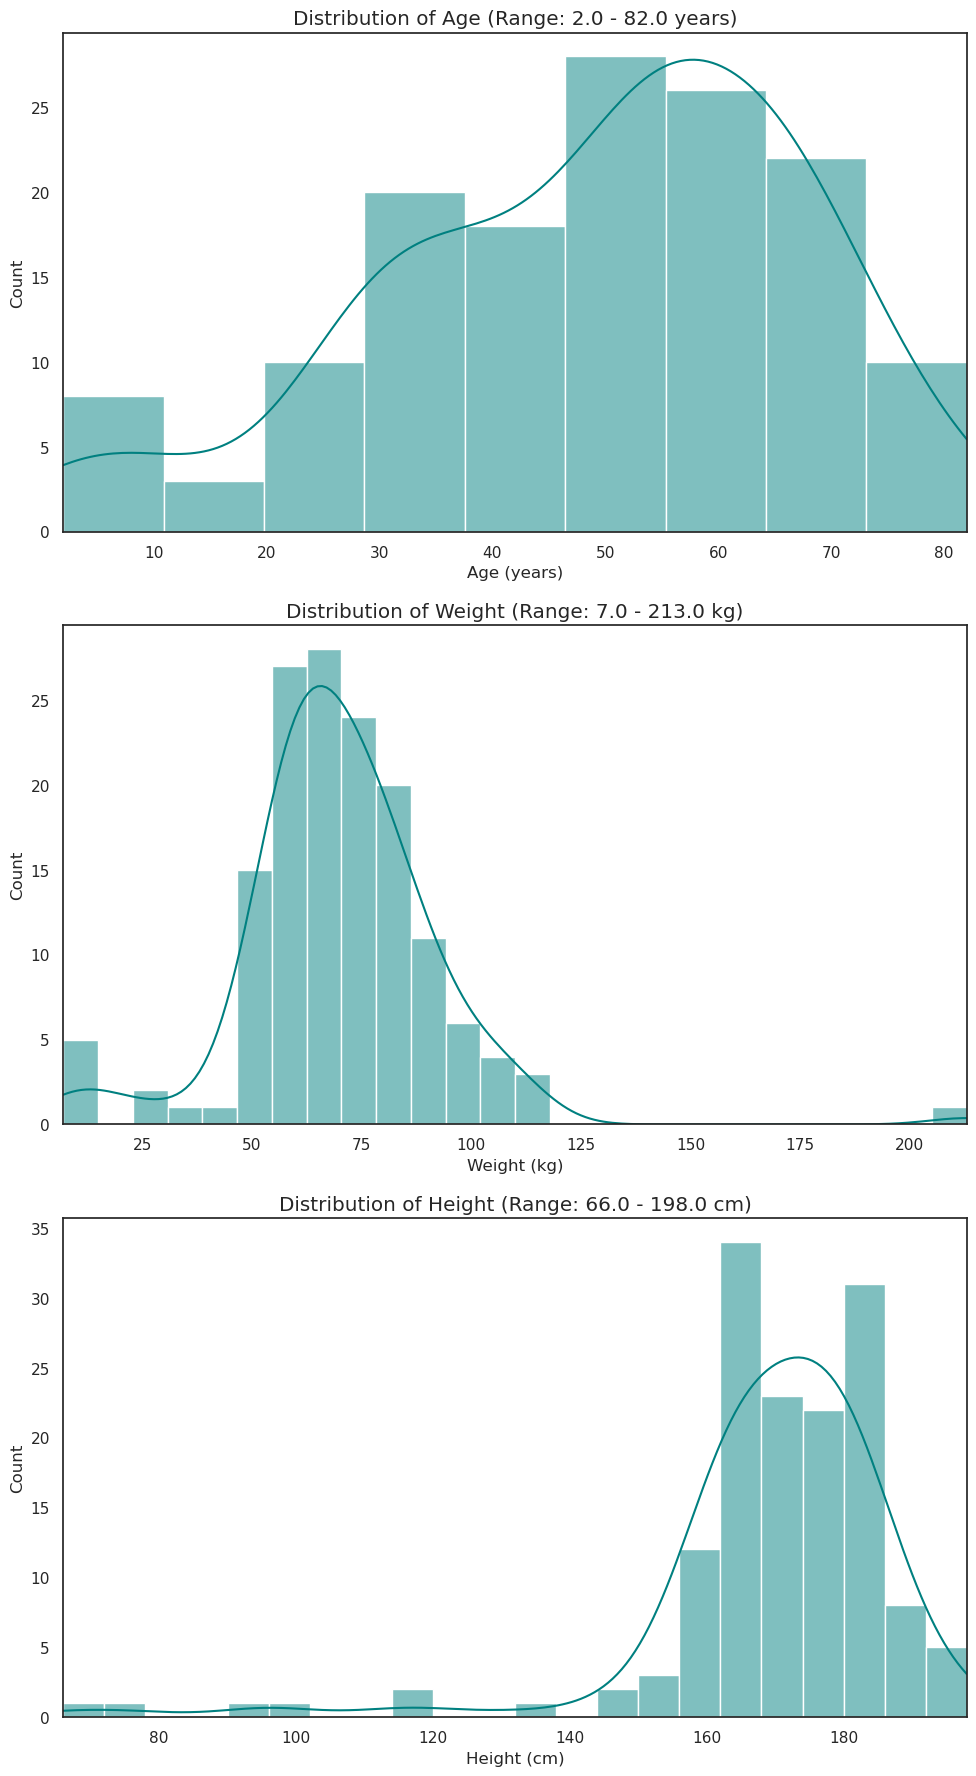

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(10, 18))
sns.set(style='white', font_scale=1.2)

subset_age = metadata_ed.dropna(subset=['age_years_sample'])
min_age = subset_age['age_years_sample'].min()
max_age = subset_age['age_years_sample'].max()

sns.histplot(
    data=subset_age,
    x='age_years_sample',
    kde=True,
    binrange=(min_age, max_age),
    color='teal',
    edgecolor='white',
    ax=axes[0]
)
axes[0].set_xlim(min_age, max_age)
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Distribution of Age (Range: {min_age} - {max_age} years)')

subset_weight = metadata_ed.dropna(subset=['weight_kg_sample'])
min_weight = subset_weight['weight_kg_sample'].min()
max_weight = subset_weight['weight_kg_sample'].max()

sns.histplot(
    data=subset_weight,
    x='weight_kg_sample',
    kde=True,
    binrange=(min_weight, max_weight),
    color='teal',
    edgecolor='white',
    ax=axes[1]
)
axes[1].set_xlim(min_weight, max_weight)
axes[1].set_xlabel('Weight (kg)')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Distribution of Weight (Range: {min_weight} - {max_weight} kg)')

subset_height = metadata_ed.dropna(subset=['height_cm_sample'])
min_height = subset_height['height_cm_sample'].min()
max_height = subset_height['height_cm_sample'].max()

sns.histplot(
    data=subset_height,
    x='height_cm_sample',
    kde=True,
    binrange=(min_height, max_height),
    color='teal',
    edgecolor='white',
    ax=axes[2]
)
axes[2].set_xlim(min_height, max_height)
axes[2].set_xlabel('Height (cm)')
axes[2].set_ylabel('Count')
axes[2].set_title(f'Distribution of Height (Range: {min_height} - {max_height} cm)')

plt.tight_layout()
plt.show()

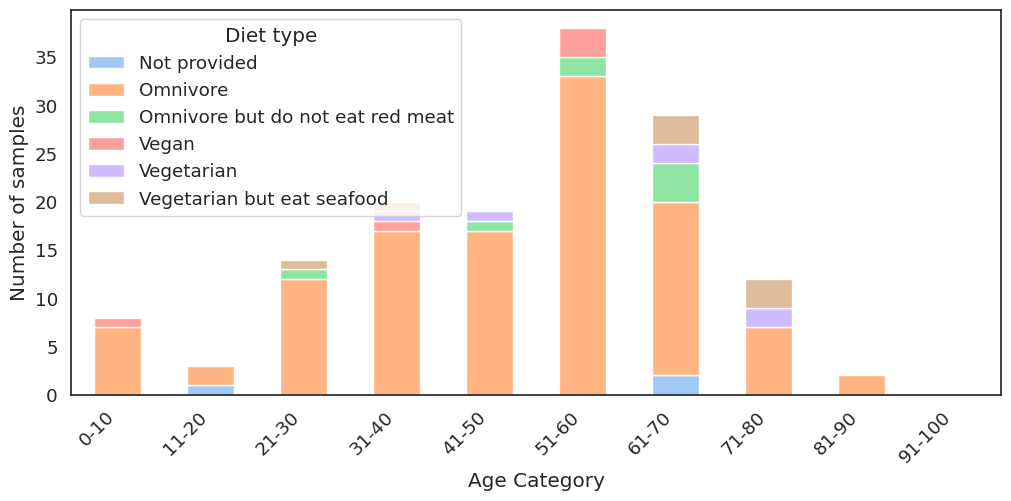

In [33]:
metadata_ed.loc[:, 'age_category'] = pd.cut(
    metadata_ed['age_years_sample'],
    bins=bins_age,
    labels=labels_age,
    include_lowest=True)

subset = metadata_ed.dropna(subset=['age_category', 'diet_type_sample'])
grouped = subset.groupby(
    ['age_category', 'diet_type_sample'],
    observed=False
).size().reset_index(name='sample_count')

stacked = grouped.pivot(
    index='age_category',
    columns='diet_type_sample',
    values='sample_count'
).fillna(0)

num_bars = stacked.shape[1]  
colors = sns.color_palette("pastel", num_bars)


with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(12, 5))

    stacked.plot(
        kind='bar',
        stacked=True,
        color=colors,    
        ax=ax)
    ax.set_xlabel('Age Category')
    ax.set_ylabel('Number of samples')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    legend = ax.get_legend()
    legend.set_title('Diet type')


plt.show()

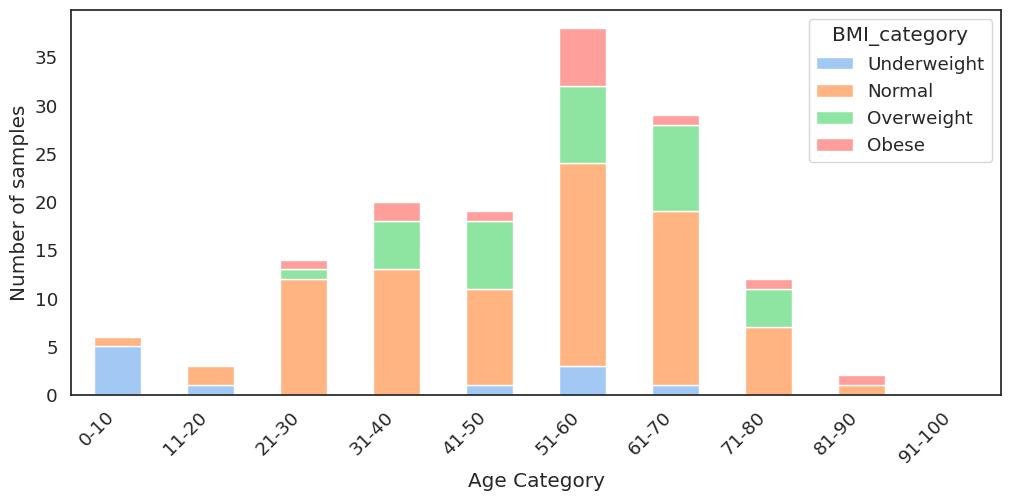

In [34]:
metadata_ed.loc[:, 'age_category'] = pd.cut(
    metadata_ed['age_years_sample'],
    bins=bins_age,
    labels=labels_age,
    include_lowest=True)

subset = metadata_ed.dropna(subset=['age_category', 'BMI_category'])
grouped = subset.groupby(
    ['age_category', 'BMI_category'],
    observed=False
).size().reset_index(name='sample_count')

stacked = grouped.pivot(
    index='age_category',
    columns='BMI_category',
    values='sample_count'
).fillna(0)

num_bars = stacked.shape[1]  
colors = sns.color_palette("pastel", num_bars)


with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(12, 5))

    stacked.plot(
        kind='bar',
        stacked=True,
        color=colors,    
        ax=ax)
    ax.set_xlabel('Age Category')
    ax.set_ylabel('Number of samples')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    legend = ax.get_legend()
    legend.set_title('BMI_category')


plt.show()

#### Location

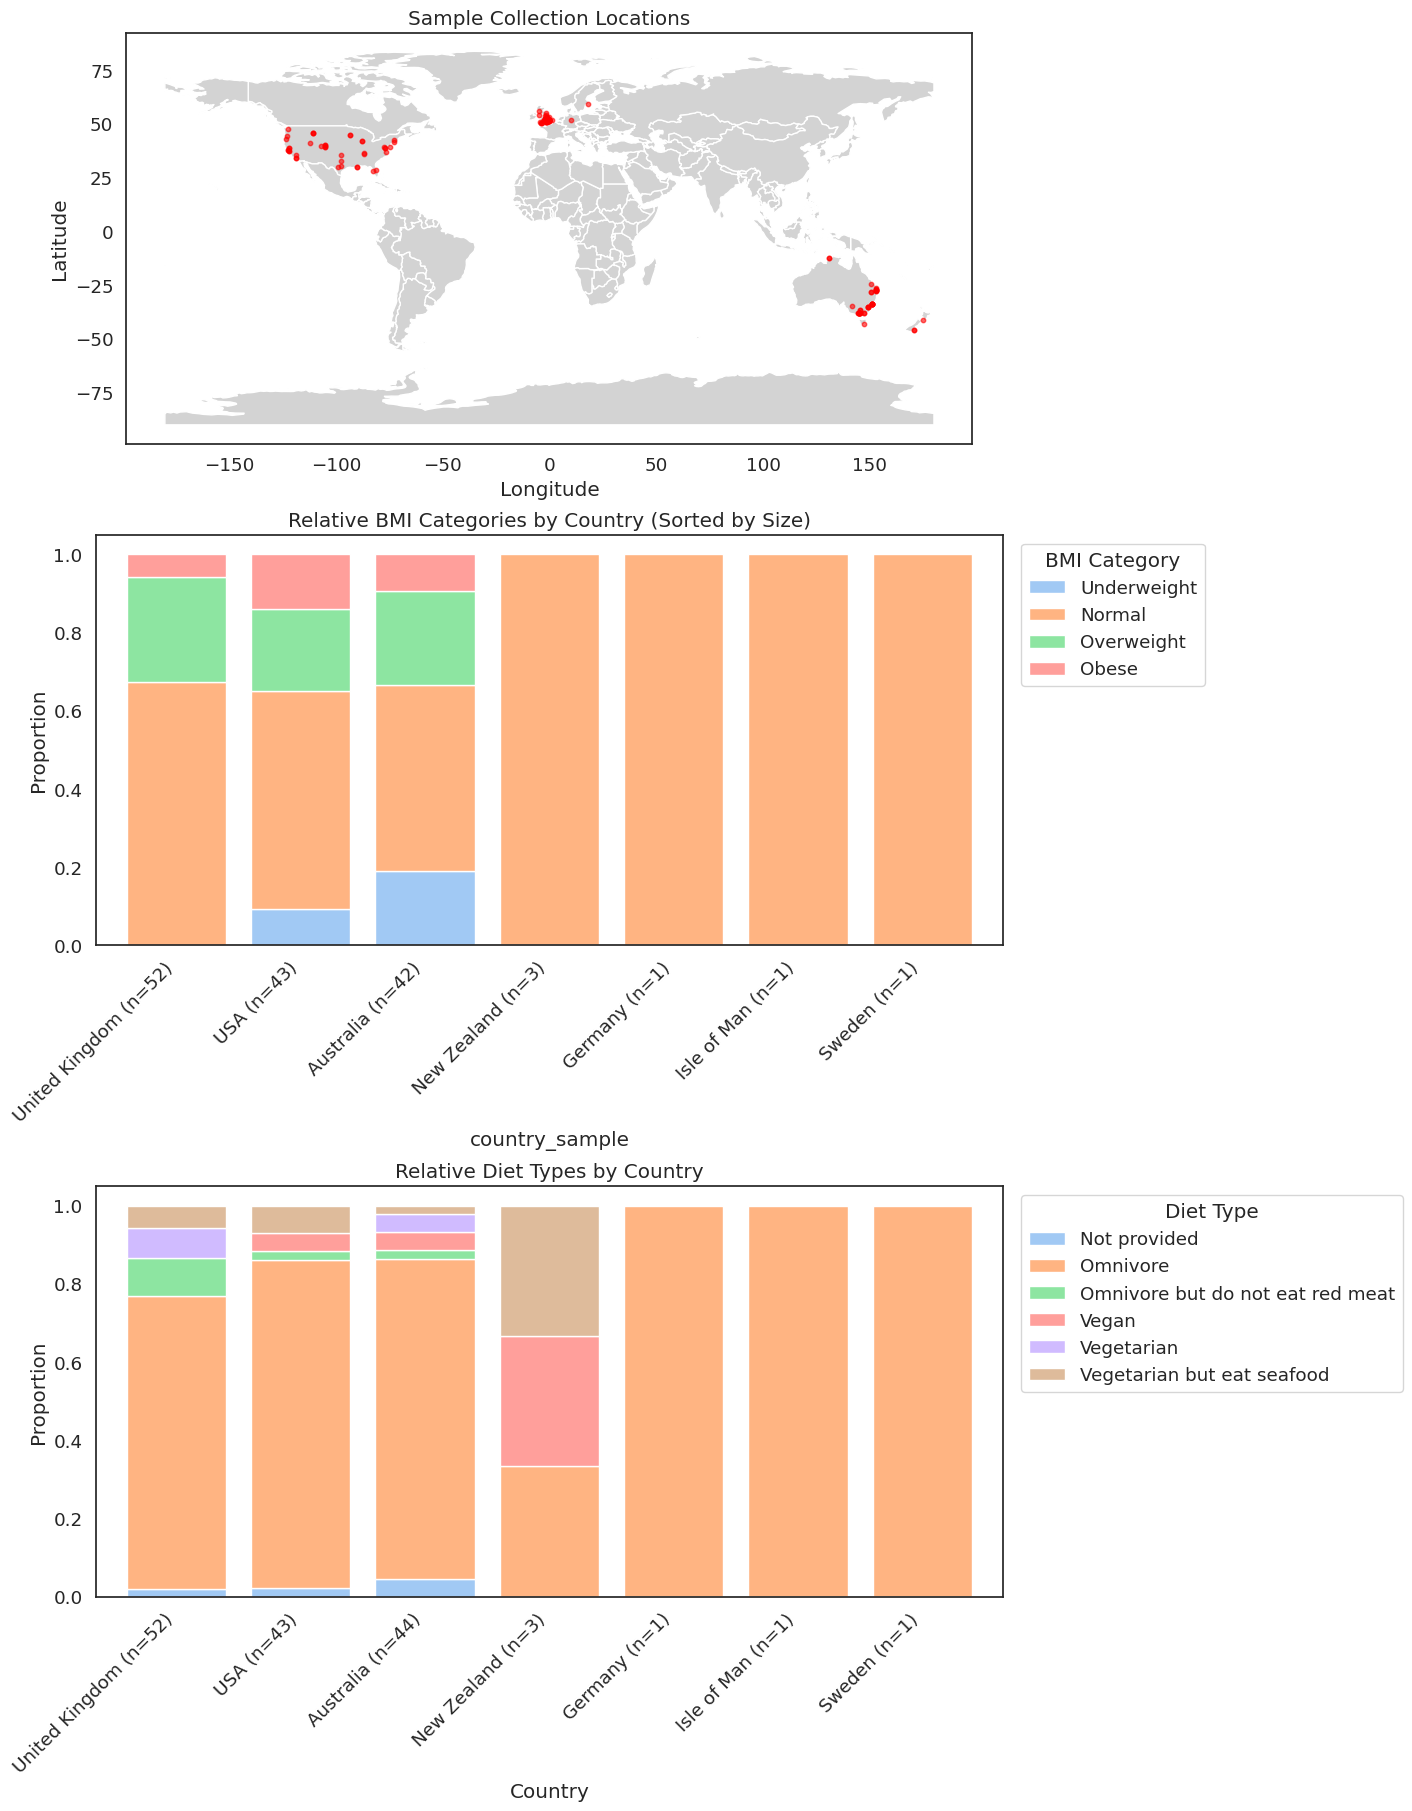

In [35]:
# 2. PREPARE GEOMETRY (MAP DATA)
metadata_ed['longitude_sample'] = pd.to_numeric(metadata_ed['longitude_sample'], errors='coerce')
metadata_ed['latitude_sample']  = pd.to_numeric(metadata_ed['latitude_sample'], errors='coerce')

metadata_ed = metadata_ed.dropna(subset=['longitude_sample', 'latitude_sample']).copy()

metadata_ed["geometry"] = metadata_ed.apply(
    lambda row: Point(row["longitude_sample"], row["latitude_sample"]),
    axis=1
)

gdf = gpd.GeoDataFrame(metadata_ed, geometry="geometry", crs="EPSG:4326")

# Load World Map
# Note: This requires internet access. If offline, use gpd.datasets.get_path('naturalearth_lowres')
url_world = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url_world)

# 3. PREPARE BMI DATA (PLOT 2)
country_col = 'country_sample' 
bmi_col = 'BMI_category'

subset_bmi = metadata_ed.dropna(subset=[country_col, bmi_col]).copy()

grouped_bmi = (
    subset_bmi.groupby([country_col, bmi_col], observed=False)
          .size()
          .reset_index(name='sample_count')
)

stacked_bmi = grouped_bmi.pivot(
    index=country_col,
    columns=bmi_col,
    values='sample_count'
).fillna(0)

# Sort countries by number of BMI samples (This defines the Master Order)
total_n_bmi = stacked_bmi.sum(axis=1)
sorted_countries = total_n_bmi.sort_values(ascending=False).index

# Reorder BMI data
stacked_bmi = stacked_bmi.loc[sorted_countries]
total_n_bmi = stacked_bmi.sum(axis=1) # Recalculate to match order

# Relative proportions (BMI)
stacked_bmi_rel = stacked_bmi.div(total_n_bmi, axis=0)

# Labels with sample sizes (for BMI plot)
labels_bmi = [f"{country} (n={int(count)})" for country, count in zip(total_n_bmi.index, total_n_bmi)]

# 4. PREPARE DIET DATA (PLOT 3)
diet_col = 'diet_type_sample'

subset_diet = metadata_ed.dropna(subset=[country_col, diet_col]).copy()

grouped_diet = (
    subset_diet.groupby([country_col, diet_col], observed=False)
          .size()
          .reset_index(name='sample_count')
)

stacked_diet = grouped_diet.pivot(
    index=country_col,
    columns=diet_col,
    values='sample_count'
).fillna(0)

# ALIGNMENT: Reindex Diet data to match the sorted Country order from the BMI plot
stacked_diet = stacked_diet.reindex(sorted_countries).fillna(0)
total_n_diet = stacked_diet.sum(axis=1)

# Relative proportions (Diet)
# We fillna(0) in case a country has 0 diet samples to avoid NaN errors
stacked_diet_rel = stacked_diet.div(total_n_diet, axis=0).fillna(0)

# Labels for Diet plot (might differ slightly if some samples lack diet data)
labels_diet = [f"{country} (n={int(count)})" for country, count in zip(total_n_diet.index, total_n_diet)]


# 5. PLOTTING
# Define Colors
colors_bmi = sns.color_palette("pastel", stacked_bmi.shape[1])
colors_diet = sns.color_palette("pastel", stacked_diet.shape[1]) # Different palette for Diet

# Create combined figure (3 rows)
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(14, 18),
    constrained_layout=True
)

# --- PLOT 1: World Map ---
ax1 = axes[0]
world.plot(ax=ax1, color="lightgray", edgecolor="white")
gdf.plot(ax=ax1, color="red", markersize=10, alpha=0.6)
ax1.set_title("Sample Collection Locations")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# --- PLOT 2: BMI Distribution ---
ax2 = axes[1]
stacked_bmi_rel.plot(
    ax=ax2,
    kind='bar',
    stacked=True,
    color=colors_bmi,
    edgecolor='white',
    width=0.8
)
ax2.set_ylabel('Proportion')
ax2.set_title('Relative BMI Categories by Country (Sorted by Size)')
# Hide x-labels here to avoid clutter, since Plot 3 has them? 
# Or keep them if you want to see n=... for BMI specifically.
ax2.set_xticklabels(labels_bmi, rotation=45, ha='right')
ax2.legend(title='BMI Category', bbox_to_anchor=(1.01, 1), loc='upper left')

# --- PLOT 3: Diet Distribution ---
ax3 = axes[2]
stacked_diet_rel.plot(
    ax=ax3,
    kind='bar',
    stacked=True,
    color=colors_diet,
    edgecolor='white',
    width=0.8
)
ax3.set_xlabel('Country')
ax3.set_ylabel('Proportion')
ax3.set_title('Relative Diet Types by Country')
ax3.set_xticklabels(labels_diet, rotation=45, ha='right')
ax3.legend(title='Diet Type', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.show()

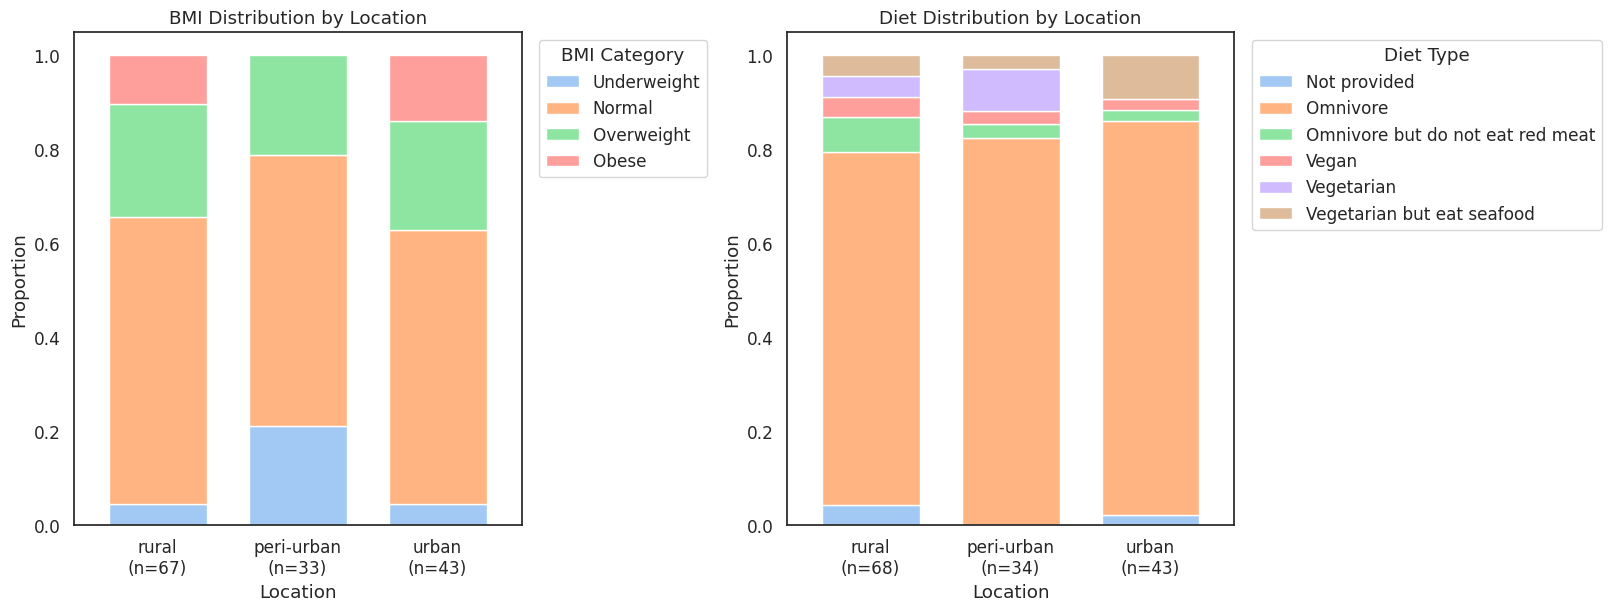

In [37]:
# 1. SETUP VARIABLES
loc_col = 'urban_rural' 
bmi_col = 'BMI_category'
diet_col = 'diet_type_sample' 

# --- CORRECTION HERE: UPDATED TO LOWERCASE ---
# We use the specific order: Rural -> Peri-urban -> Urban
x_order = ['rural', 'peri-urban', 'urban'] 

# 2. HELPER FUNCTION
def get_stacked_data(df, group_col, stack_col, order_list):
    # Filter for non-empty data
    subset = df.dropna(subset=[group_col, stack_col]).copy()
    
    # Group
    grouped = subset.groupby([group_col, stack_col], observed=False).size().reset_index(name='count')
    
    if grouped.empty:
        return None, [], 0

    # Pivot
    stacked = grouped.pivot(index=group_col, columns=stack_col, values='count').fillna(0)
    
    # Filter by specific order (Only keep existing categories)
    valid_order = [x for x in order_list if x in stacked.index]
    
    if not valid_order:
        print(f"ERROR: Data mismatch. Your data has: {list(stacked.index)}")
        return None, [], 0
        
    stacked = stacked.loc[valid_order]
    
    # Calculate Proportions
    total_n = stacked.sum(axis=1)
    stacked_rel = stacked.div(total_n, axis=0)
    
    labels = [f"{loc}\n(n={int(n)})" for loc, n in zip(total_n.index, total_n)]
    
    return stacked_rel, labels, stacked.shape[1]

# 3. PLOTTING
sns.set(style='white', font_scale=1.1)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# --- PLOT 1: BMI ---
bmi_data, bmi_labels, bmi_n = get_stacked_data(metadata_ed, loc_col, bmi_col, x_order)

if bmi_data is not None:
    colors_bmi = sns.color_palette("pastel", bmi_n)
    bmi_data.plot(kind='bar', stacked=True, color=colors_bmi, edgecolor='white', width=0.7, ax=axes[0])
    axes[0].set_title("BMI Distribution by Location")
    axes[0].set_xlabel("Location")
    axes[0].set_ylabel("Proportion")
    axes[0].set_xticklabels(bmi_labels, rotation=0)
    axes[0].legend(title='BMI Category', bbox_to_anchor=(1.02, 1), loc='upper left')

# --- PLOT 2: DIET ---
diet_data, diet_labels, diet_n = get_stacked_data(metadata_ed, loc_col, diet_col, x_order)

if diet_data is not None:
    colors_diet = sns.color_palette("pastel", diet_n)
    diet_data.plot(kind='bar', stacked=True, color=colors_diet, edgecolor='white', width=0.7, ax=axes[1])
    axes[1].set_title("Diet Distribution by Location")
    axes[1].set_xlabel("Location")
    axes[1].set_ylabel("Proportion")
    axes[1].set_xticklabels(diet_labels, rotation=0)
    axes[1].legend(title='Diet Type', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.show()

#### Diet type and BMI

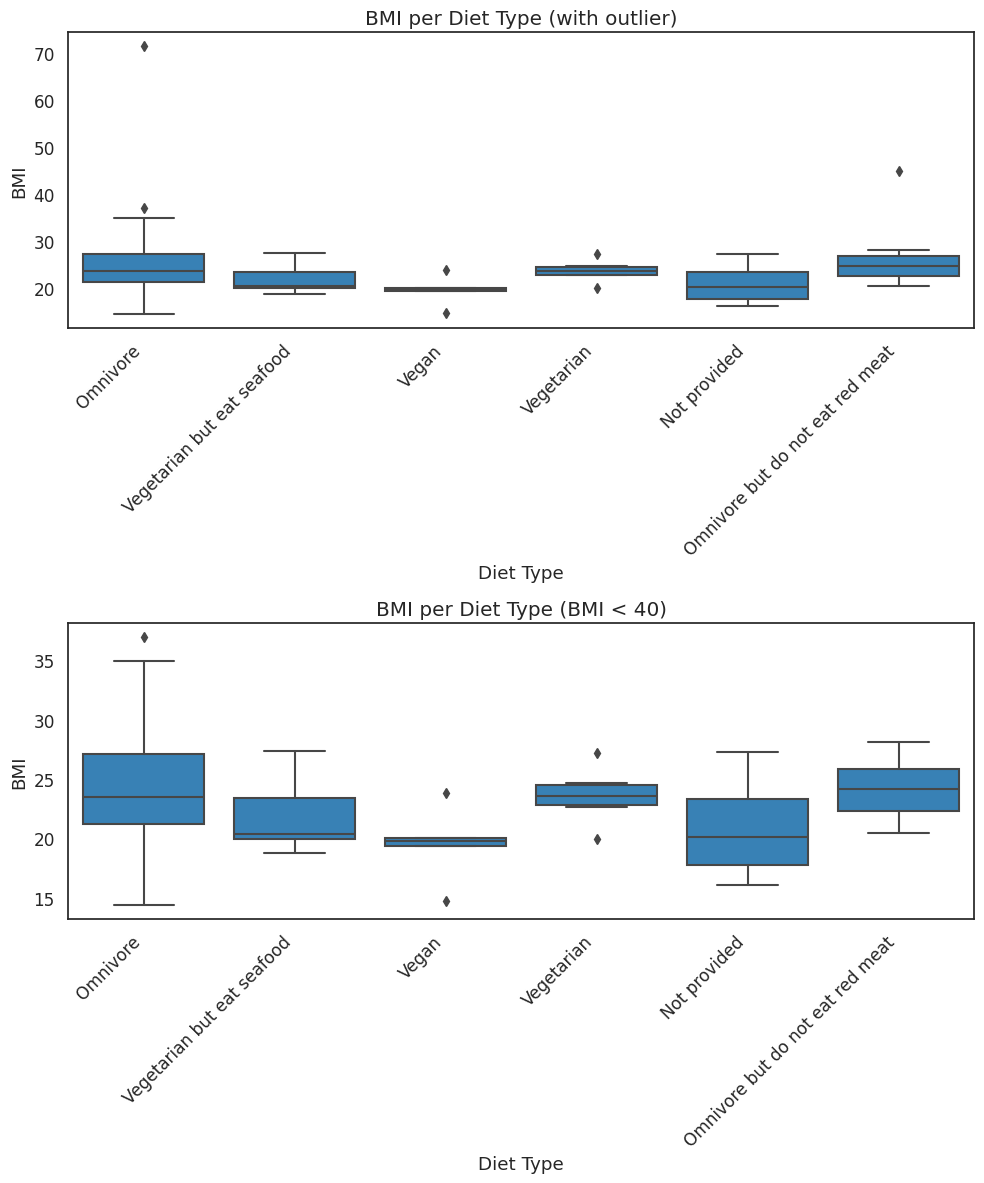

In [38]:
subset_full = metadata_rucc.dropna(
    subset=['diet_type_sample', 'bmi_sample']
).copy()

subset_no_outlier = subset_full[subset_full['bmi_sample'] < 40].copy()


fig, axes = plt.subplots(2, 1, figsize=(10, 12))

sns.set(style='white')

with sns.plotting_context("notebook", font_scale=1.2):

# With outliers
    sns.boxplot(
        data=subset_full,
        x='diet_type_sample',
        y='bmi_sample',
        color='#2385ca',
        ax=axes[0]
    )
    axes[0].set_title("BMI per Diet Type (with outlier)")
    axes[0].set_xlabel("Diet Type")
    axes[0].set_ylabel("BMI")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# No outliers
    sns.boxplot(
        data=subset_no_outlier,
        x='diet_type_sample',
        y='bmi_sample',
        color='#2385ca',
        ax=axes[1]
    )
    axes[1].set_title("BMI per Diet Type (BMI < 40)")
    axes[1].set_xlabel("Diet Type")
    axes[1].set_ylabel("BMI")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

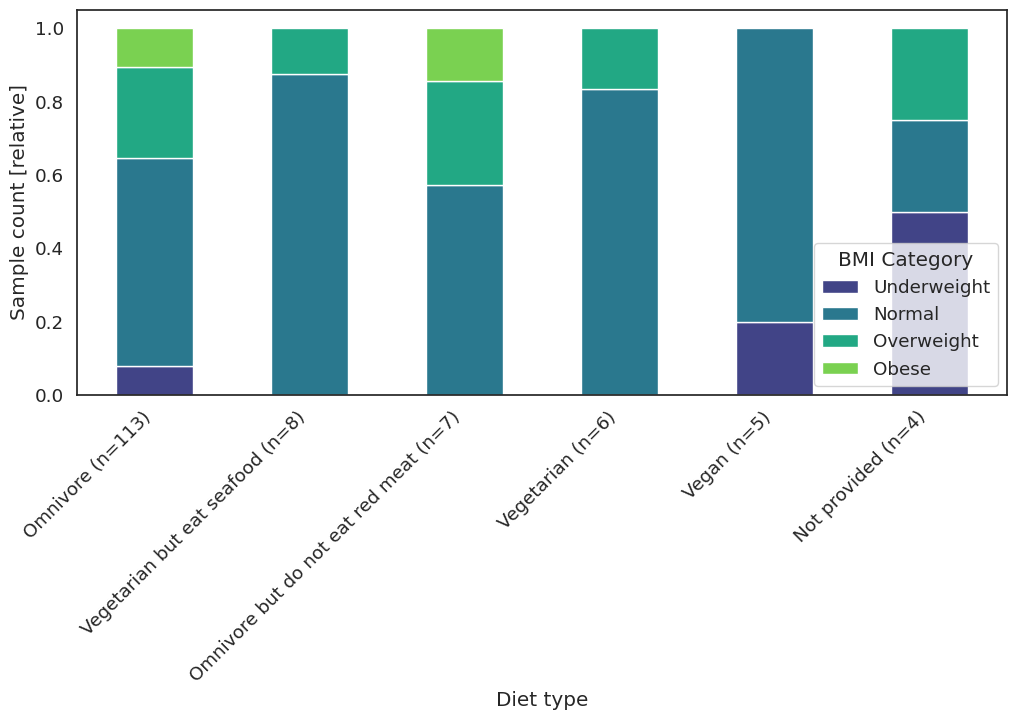

In [39]:
# 1. PREPARE DATA
subset = metadata_ed.dropna(subset=['diet_type_sample', 'BMI_category']).copy()

grouped = subset.groupby(['diet_type_sample', 'BMI_category'], observed=False) \
                .size() \
                .reset_index(name='sample_count')

stacked = grouped.pivot(
    index='diet_type_sample',
    columns='BMI_category',
    values='sample_count'
).fillna(0)

# --- NEW SORTING BLOCK ---
# 1. Calculate row totals
total_n = stacked.sum(axis=1)

# 2. Sort countries by sample count (Largest to Smallest)
sorted_index = total_n.sort_values(ascending=False).index
stacked = stacked.loc[sorted_index]
total_n = total_n.loc[sorted_index] # Sync totals to new order

# 3. Create Custom Labels
new_labels = [f"{idx} (n={int(n)})" for idx, n in zip(total_n.index, total_n)]
# -------------------------

# Calculate Relative Frequencies using the SORTED data
stacked_rel = stacked.div(total_n, axis=0)

# Define Colors (Moved here so 'stacked' is defined)
num_bars = stacked.shape[1] 
colors = sns.color_palette("viridis", num_bars)

sns.set(rc={'figure.figsize': (12, 5)}, style='white')

with sns.plotting_context("notebook", font_scale=1.2):

    ax = stacked_rel.plot(
        kind='bar',
        stacked=True,
        color=colors)

    ax.set_xlabel('Diet type')
    ax.set_ylabel('Sample count [relative]')
    
    # Apply the new labels with n=x
    ax.set_xticklabels(new_labels, rotation=45, ha='right')

    legend = ax.get_legend()
    legend.set_title('BMI Category')

plt.show()

#### Diseases

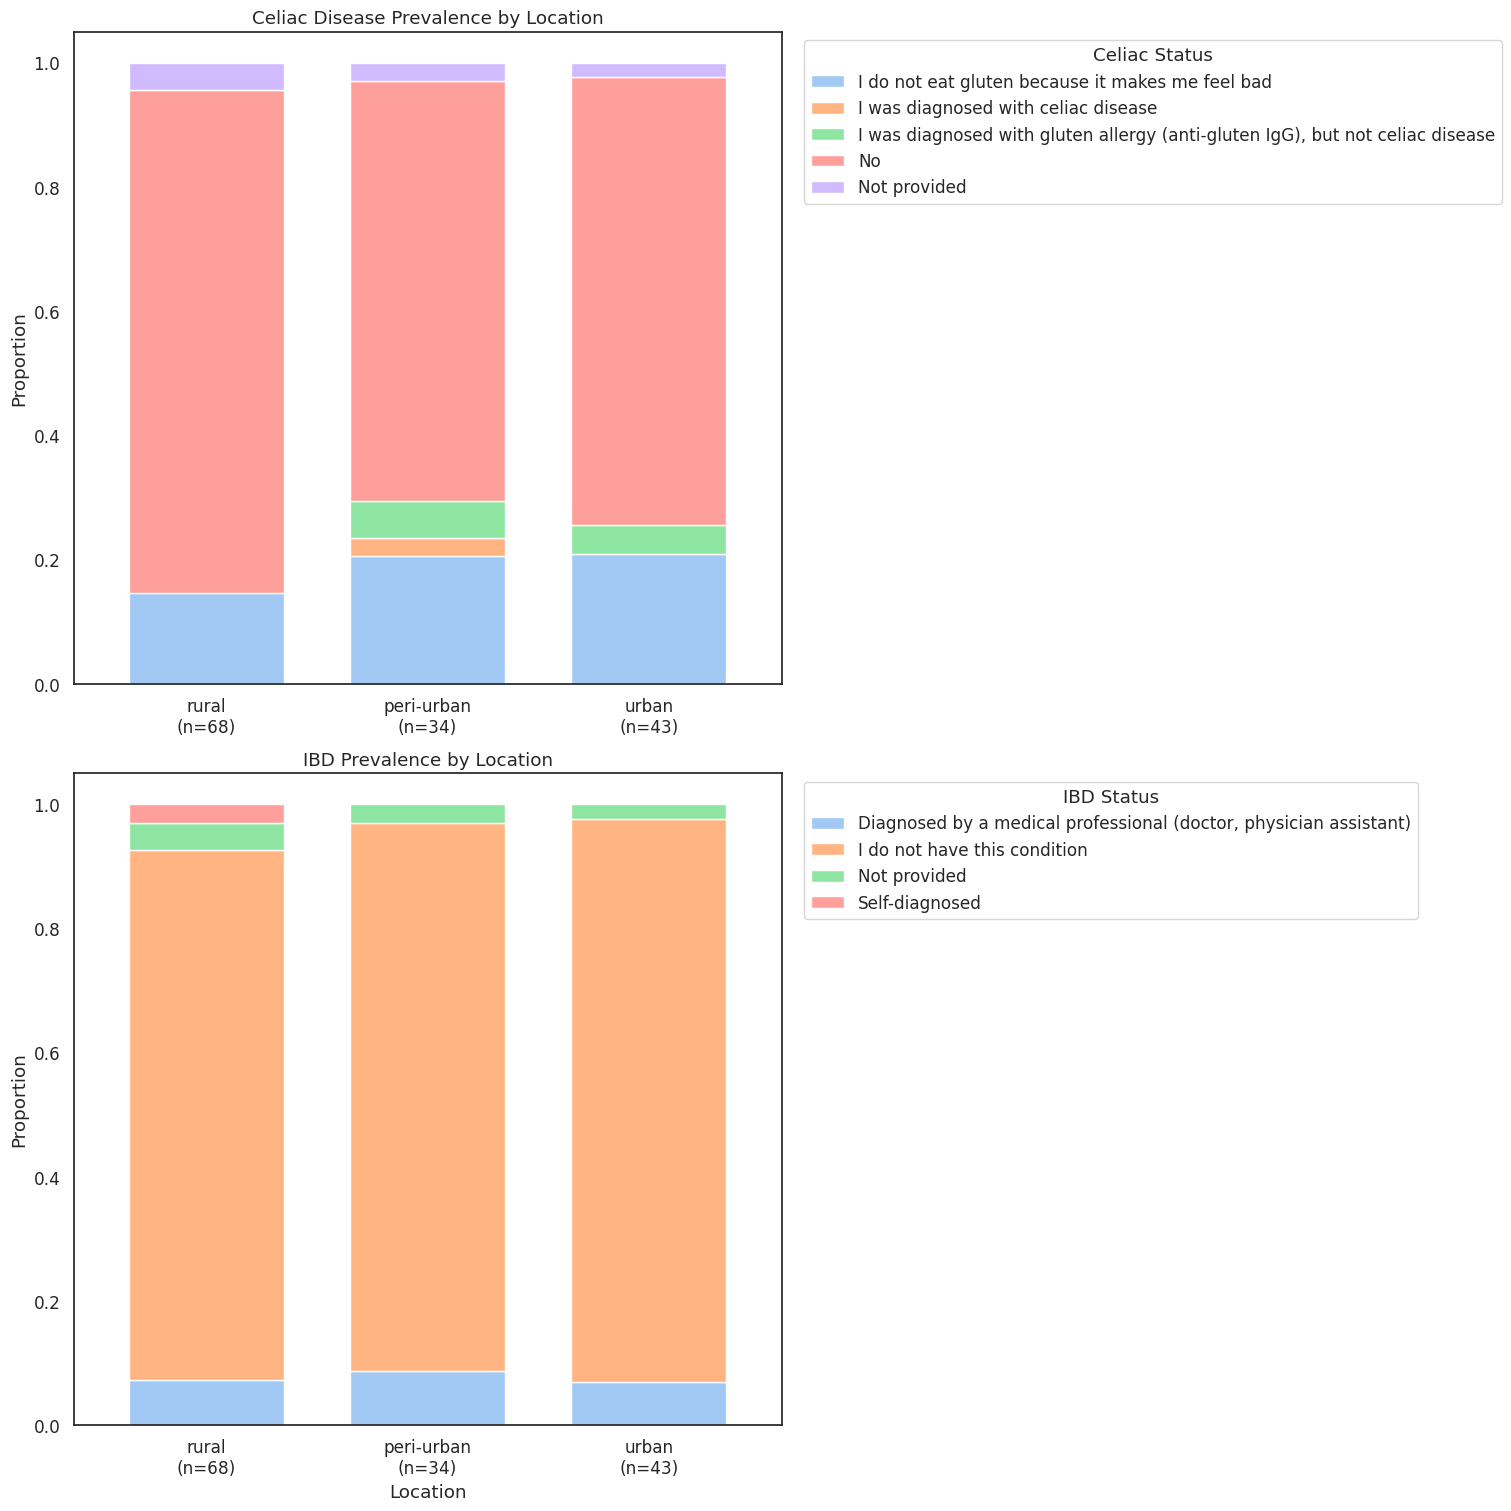

In [41]:
# 1. SETUP VARIABLES
loc_col = 'urban_rural'
celiac_col = 'gluten_sample'
ibd_col = 'ibd_sample'

# Define the specific order
x_order = ['rural', 'peri-urban', 'urban']

# 2. HELPER FUNCTION
def get_stacked_data(df, group_col, stack_col, order_list):
    # Filter for non-missing data
    subset = df.dropna(subset=[group_col, stack_col]).copy()
    
    # Group and Pivot
    grouped = subset.groupby([group_col, stack_col], observed=False).size().reset_index(name='count')
    
    if grouped.empty:
        return None, [], 0

    stacked = grouped.pivot(index=group_col, columns=stack_col, values='count').fillna(0)
    
    # Enforce strict x-axis order
    valid_order = [x for x in order_list if x in stacked.index]
    if not valid_order:
        print(f"Warning: No matching locations found for {stack_col}. Data has: {list(stacked.index)}")
        return None, [], 0
        
    stacked = stacked.loc[valid_order]
    
    # Calculate Proportions (0.0 to 1.0)
    total_n = stacked.sum(axis=1)
    stacked_rel = stacked.div(total_n, axis=0)
    
    # Create labels with sample sizes
    labels = [f"{loc}\n(n={int(n)})" for loc, n in zip(total_n.index, total_n)]
    
    return stacked_rel, labels, stacked.shape[1]

# 3. GENERATE PLOTS (STACKED VERTICALLY)
sns.set(style='white', font_scale=1.1)

# CHANGED: nrows=2, ncols=1, and height=12
fig, axes = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)

# --- TOP PLOT: Celiac Disease ---
celiac_data, celiac_labels, c_num = get_stacked_data(metadata_ed, loc_col, celiac_col, x_order)

if celiac_data is not None:
    colors = sns.color_palette("pastel", c_num) 
    celiac_data.plot(
        kind='bar', stacked=True, color=colors, 
        edgecolor='white', width=0.7, ax=axes[0]
    )
    axes[0].set_title("Celiac Disease Prevalence by Location")
    axes[0].set_ylabel("Proportion")
    # Removed x-label title to avoid clutter, since bottom plot explains it
    axes[0].set_xlabel("") 
    axes[0].set_xticklabels(celiac_labels, rotation=0)
    axes[0].legend(title='Celiac Status', bbox_to_anchor=(1.02, 1), loc='upper left')

# --- BOTTOM PLOT: IBD ---
ibd_data, ibd_labels, i_num = get_stacked_data(metadata_ed, loc_col, ibd_col, x_order)

if ibd_data is not None:
    colors = sns.color_palette("pastel", i_num)
    ibd_data.plot(
        kind='bar', stacked=True, color=colors, 
        edgecolor='white', width=0.7, ax=axes[1]
    )
    axes[1].set_title("IBD Prevalence by Location")
    axes[1].set_ylabel("Proportion")
    axes[1].set_xlabel("Location")
    axes[1].set_xticklabels(ibd_labels, rotation=0)
    axes[1].legend(title='IBD Status', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.show()

Lets follow up on us not seeing any cases of diagnosed celiac disease in rural areas by performing a Monte Carlo Chi square simulation to see if the values we see could appear randomly.

In [42]:
def monte_carlo_chi_square(table, n_sim=10000, seed=0):
    """
    Monte Carlo chi-square test for independence in RxC tables.
    
    Parameters:
        table: pandas DataFrame (contingency table)
        n_sim: number of random permutations
        seed: random seed
        
    Returns:
        observed chi2, p-value, df, expected table
    """
    np.random.seed(seed)
    
    # compute real chi-square
    chi2_obs, p, dof, expected = chi2_contingency(table, correction=False)
    
    # flatten observed table into list of labels
    rows = table.index.to_numpy()
    cols = table.columns.to_numpy()
    
    # original cell counts expanded into long vector
    data_long = []
    for r in rows:
        for c in cols:
            data_long.extend([(r, c)] * table.loc[r, c])
    data_long = np.array(data_long, dtype=object)

    # Monte Carlo permutations
    chi2_sim = np.zeros(n_sim)
    
    total = len(data_long)
    for i in range(n_sim):
        # shuffle column labels only (null hypothesis: no association)
        shuffled = data_long.copy()
        np.random.shuffle(shuffled[:, 1])

        # rebuild a contingency table
        ct_sim = pd.crosstab(shuffled[:, 0], shuffled[:, 1]).reindex(
            index=rows, columns=cols, fill_value=0
        )

        chi2_sim[i], _, _, _ = chi2_contingency(ct_sim, correction=False)

    # Monte Carlo p-value: proportion of simulated chi2 >= observed chi2
    p_mc = np.mean(chi2_sim >= chi2_obs)

    return chi2_obs, p_mc, dof, expected

subset = metadata_ed.dropna(subset=['gluten_sample', 'urban_rural']).copy()
ct = pd.crosstab(subset['urban_rural'], subset['gluten_sample'])

chi2_obs, p_mc, dof, expected = monte_carlo_chi_square(ct, n_sim=10000)

print("Monte-Carlo Chi-Square Test (RxC, exact)")
print("----------------------------------------")
print(f"Chi2 statistic:      {chi2_obs:.4f}")
print(f"Monte-Carlo p-value: {p_mc:.6f}")
print(f"Degrees of freedom:  {dof}")
print("Womp-womp: no significance :(")

Monte-Carlo Chi-Square Test (RxC, exact)
----------------------------------------
Chi2 statistic:      8.6165
Monte-Carlo p-value: 0.374000
Degrees of freedom:  8
Womp-womp: no significance :(


/tmp/ipykernel_37441/1510966399.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


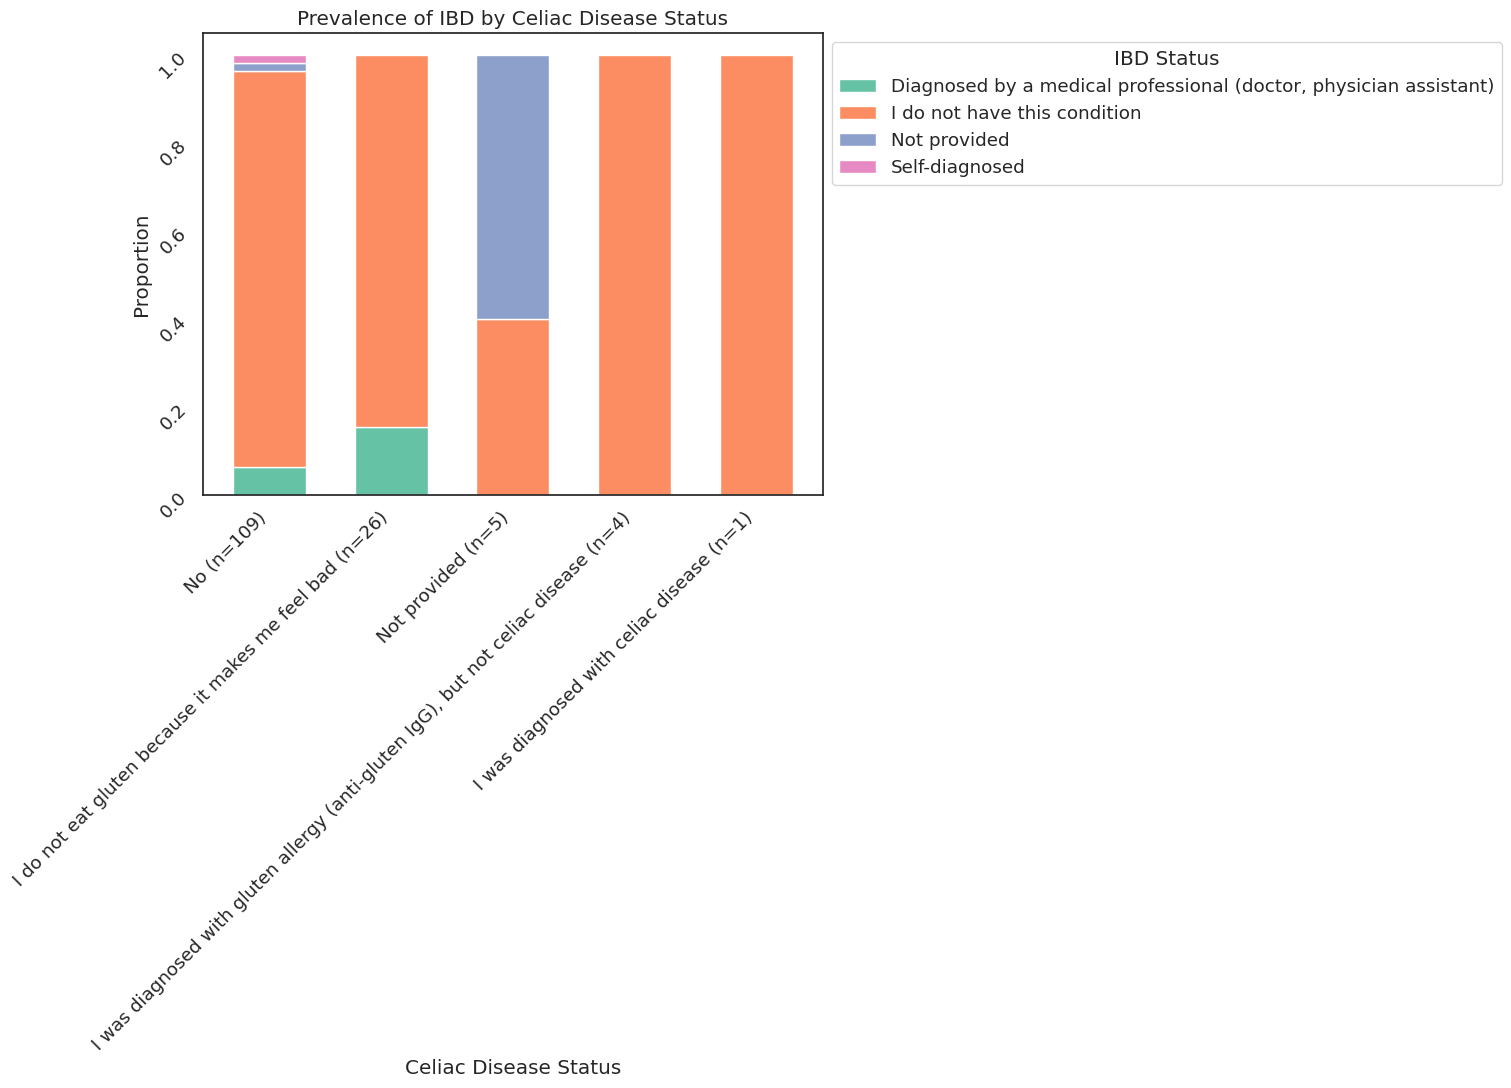

In [43]:
# 1. SETUP VARIABLES
col_celiac = 'gluten_sample' 
col_ibd = 'ibd_sample'       

# 2. PREPARE DATA
subset = metadata_ed.dropna(subset=[col_celiac, col_ibd]).copy()
crosstab = pd.crosstab(subset[col_celiac], subset[col_ibd])

# --- NEW SORTING STEP ---
# 1. Calculate the total count for each group
row_totals = crosstab.sum(axis=1)

# 2. Get the index order sorted by count (Largest -> Smallest)
sorted_index = row_totals.sort_values(ascending=False).index

# 3. Reorder the crosstab and the totals using this index
crosstab = crosstab.loc[sorted_index]
row_totals = row_totals.loc[sorted_index]

# 4. Calculate relative frequencies
crosstab_rel = crosstab.div(row_totals, axis=0)

# 5. Create labels (now they will match the sorted order automatically)
new_labels = [f"{val} (n={int(count)})" for val, count in zip(row_totals.index, row_totals)]
# ------------------------

# 3. PLOTTING
colors = sns.color_palette("Set2", n_colors=crosstab.shape[1])

sns.set(rc={'figure.figsize': (8, 6)}, style='white')

with sns.plotting_context("notebook", font_scale=1.2):
    
    ax = crosstab_rel.plot(
        kind='bar',
        stacked=True,
        color=colors,
        edgecolor='white',
        width=0.6
    )

    ax.set_xlabel('Celiac Disease Status')
    ax.set_ylabel('Proportion')
    ax.set_title('Prevalence of IBD by Celiac Disease Status')
    
    # Apply sorted custom labels
    ax.set_xticklabels(new_labels, rotation=45, ha='right')
    ax.tick_params(axis='y', labelrotation=45) 

    legend = ax.get_legend()
    legend.set_title('IBD Status')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## 01.04 Metadata findings

Based on the plots we created above, we can now summarise some of our key findings and answer directly to some of the questions about our metadata:

**Age, height, weight:**
- Age Distribution: Our cohort has a very broad age distribution ranging from just 2 years old all the way up to 82 years with a mean age of 48.8 years (std=18.8). We see that most of our participants are between the ages of 30 and 70 years old with a peak of participants aged 51-60.

- Height distribution: Again, we have a wide range of heights in our cohort with the range starting at 66cm and going all the way up to 194cm with a median of 168.5cm (std=18.9). In the plot above, we can see that we have few very short people followed a an evenly distribution of height in the area of 135-200cm.  

- Weight distribution: The distribution of weight shows one clear outlier and is otherwise fairly evenly distributed with a minimal value of 7kg and going up to the outlier at 213kg. The mean value is 69.3kg (std=22.4) and we can gather from the Dataframe-summary that 80kg is our 75% quantile. 

**Location**
- **Countries:** Almost all of our samples come from one the three regions of the UK (n=54), the USA (n=44) and Australia (n=44). Few futher samples come from New Zealand (n=3), Germany (n=2), Sweden (n=1), Isle of Man (n=1) and one person did not provide a location. 
- **Urbanicity:** Having used QGIS to categorize sample coordinates into three distinct groups, we have 68 samples from a rural place, 48 from an urban place and 34 from a peri-urban place.
- **BMI by country:** When plotting relative distributions of BMI categories by countries, we find that the vast majority of participants from all countries have a BMI in the normal range. All participants located in countries with few participants (<4) show normal BMIs. In the three countries with more participants, roughly 20-25% of participants are overweight, with 5-10% being adipose. A considerable amount of Australian Participants are underweight (16%), whereas American participants have less than half as many with the UK containing no underweight samples.
- Additional plots were created to see if there are obvious differences in Diet types by country, Diet type by urbanicity and BMI by urbanicity which will not be discussed in detail as we did not see any obvious differences.

**Diet types**

Our cohort has a very dominant diet type in omnivores (n=118). Another 8 participants reported being omnivores without earing red meat followed by another 8 who are vegetarian but eat seafood. A total of 6 partcipants is vegetarian and 5 participants are vegan. Additionally, for 5 samples we lack the information on the diet type.
This very uneven distribution of samples will make downstream analyses much more difficult as we won't be able to rely on significant testing as much due to the large group size disparities.

**Diseases**

In our metadata we have information regarding two types of diseases within our cohort; Irritable bowl disease and celiac disease. 
- **Irritable bowl disease**
A large majority of participants reports *not* having IDB (n=130), a much smaller group of participants was diagnosed by a medical professional (n=11), an additional 7 peraticipants did not provide information about their disease status and 2 participants reported having self diagnosed their IBD.
- **Celiac disease**
Similarly to IDB, the large majority of our cohort reports not having celiac disease (n=113), 26 do not eat gluten because it makes them feel bad, 6 did not provide an answer, 4 participants were diagnosed with gluten allergy but not celiac disease and just one participant was diagnosed with celiac disease.
- **Urbanicity of diseases:** We thought it interseting to visualize the prevalence of both diseases in our three different urbanicity categories with the hypothesis in mind that prevalence might be higher in urban areas compared to rural ones. We did not find an obvious difference in the prevalences of IDB based on urbanicity scores. For celiac disease, we see no cases in rural areas whereas we do see cases in peri-urban and urban areas. We followed this visual impression up by performing a Monte-Carlo Chi-Square Test which showed an insignificant pvalue (p=0.419).
- **Polyautoimmunity:** Lastly, we wanted to see if both diseases appear more often together than alone by plotting IBD status over Celiac disease. We did, however, not find a clear pattern to prove this hypothesis.

# 02 Trimming primers ✂️

Great, now that we have downloaded all raw data and have already analysed our metadata in detail, we can focus on the raw sequences and prepare them for further analysis. In this chapter we remove the primers from the sequences and then create a new summary table to check if we see any impact on the sequence length distribution (Spoiler alert: We don't).

In [44]:
! qiime cutadapt trim-single \
  --i-demultiplexed-sequences $data_dir/fungut_forward_reads.qza \
  --p-front CTTGGTCATTTAGAGGAAGTAA \
  --o-trimmed-sequences $data_dir/02/fungut_forward_reads_trimmed.qza \
  --verbose

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: cutadapt -u 0 --error-rate 0.1 --times 1 --overlap 3 --minimum-length 1 -q 0,0 --quality-base 33 --cores 1 -o /tmp/qiime2/jovyan/processes/37586-1766096851.18@jovyan/tmp/q2-OutPath-v_vg1tir/ERR5327198_01_L001_R1_001.fastq.gz --front CTTGGTCATTTAGAGGAAGTAA /tmp/qiime2/jovyan/data/3638611d-1767-413b-9390-70ee3d78e4ff/data/ERR5327198_01_L001_R1_001.fastq.gz

This is cutadapt 5.1 with Python 3.10.14
Command line parameters: -u 0 

In [45]:
"""
I put it in comments for the sake of runtime but feel free to actually run it :)
! qiime demux summarize \
  --i-data $data_dir/02/fungut_forward_reads_trimmed.qza \
  --o-visualization $data_dir/02/demux_summary_posttrimming.qzv
"""

'\nI put it in comments for the sake of runtime but feel free to actually run it :)\n! qiime demux summarize   --i-data $data_dir/02/fungut_forward_reads_trimmed.qza   --o-visualization $data_dir/02/demux_summary_posttrimming.qzv\n'

In [46]:
#Visualization.load(f"{data_dir}/02/demux_summary_posttrimming.qzv")

<div style="background-color: lightblue; padding: 20px;">
Trimming our primers we can see that only 0.1% of feautres have been edited. Hence, we assume that the primers have already been trimmed as otherwise we would expect many more feautres to have been adjusted.
</div>



# 03 Denoising 🔊 

Perfect! Now we're all set to start working with our demultiplexed and trimmed sequences. We start by denoising the sequences to recieve the holy feature table and the denoised sequences that will be the basis of all downstream processing.

- Weli settings heimer brucht
- Denoising benchmarking vor livia

## 03.01 Denoising benchmarking

(LIVIA SCHRIBE) We tried out several denoising settings to see how they affect both sequence quality and the number of features we keep. To do so we ....

### Running Dada2 for different parameter combinations

To start off our denoising benchmarking, lets run the denoising steps for the chosen cobinateions of parameters. As this will take loots of time, we ran the denoising runs on Euler. The script below is the code we ran outside of a loop on our personal devices. Below we decided to portray it as a loop to shorten the cell.

In [47]:
"""
for i in $(seq 1 7); do
  echo "Running dada2 with min-fold-parent-over-abundance=$i and max-ee=$i ..."
  !qiime dada2 denoise-single \
    --i-demultiplexed-seqs "$data_dir/02/fungut_forward_reads.qza" \
    --p-trim-left 0 \
    --p-trunc-len 0 \
    --p-min-fold-parent-over-abundance "$i" \
    --p-max-ee "$i" \
    --o-denoising-stats "$data_dir/03/adapt/${i}_dada2_stats.qza"
"""

'\nfor i in $(seq 1 7); do\n  echo "Running dada2 with min-fold-parent-over-abundance=$i and max-ee=$i ..."\n  !qiime dada2 denoise-single     --i-demultiplexed-seqs "$data_dir/02/fungut_forward_reads.qza"     --p-trim-left 0     --p-trunc-len 0     --p-min-fold-parent-over-abundance "$i"     --p-max-ee "$i"     --o-denoising-stats "$data_dir/03/adapt/${i}_dada2_stats.qza"\n'

### Importing the denoising steps

In [48]:
!wget "https://polybox.ethz.ch/index.php/s/sTds5dxMqfDqtWN/download" -O $data_dir/03/benchmarking/stats.zip

--2025-12-18 23:29:36--  https://polybox.ethz.ch/index.php/s/sTds5dxMqfDqtWN/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘data/03/benchmarking/stats.zip’

data/03/benchmarkin     [  <=>               ] 372.38K  1.62MB/s    in 0.2s    

2025-12-18 23:29:36 (1.62 MB/s) - ‘data/03/benchmarking/stats.zip’ saved [381315]



In [49]:
! unzip $data_dir/03/benchmarking/stats.zip -d $data_dir/03/benchmarking

Archive:  data/03/benchmarking/stats.zip
   creating: data/03/benchmarking/stats/
 extracting: data/03/benchmarking/stats/1_dada2_stats.qza  
 extracting: data/03/benchmarking/stats/2_dada2_stats.qza  
 extracting: data/03/benchmarking/stats/3_dada2_stats.qza  
 extracting: data/03/benchmarking/stats/4_dada2_stats.qza  
 extracting: data/03/benchmarking/stats/5_dada2_stats.qza  
 extracting: data/03/benchmarking/stats/6_dada2_stats.qza  
 extracting: data/03/benchmarking/stats/7_dada2_stats.qza  


In [50]:
for i in range(1, 8):
    ! qiime tools export --input-path "$data_dir/03/benchmarking/stats/{i}_dada2_stats.qza" --output-path "$data_dir/03/benchmarking/stats/stats{i}"


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Exported data/03/benchmarking/stats/1_dada2_stats.qza as DADA2StatsDirFmt to directory data/03/benchmarking/stats/stats1
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Exported data/03/benchmarking/stats/2_dada2_stats.qza as DADA2StatsDirFmt to directory data/03/benchmarking/stats/stats2
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecate

### Reading in the stats

In [51]:
df_stats1 = pd.read_csv(f"{data_dir}/03/benchmarking/stats/stats1/stats.tsv", sep="\t")
df_stats1 = df_stats1.iloc[1:].reset_index(drop=True)
df_stats1 = df_stats1.apply(pd.to_numeric, errors='coerce')

df_stats2 = pd.read_csv(f"{data_dir}/03/benchmarking/stats/stats2/stats.tsv", sep="\t")
df_stats2 = df_stats2.iloc[1:].reset_index(drop=True)
df_stats2 = df_stats2.apply(pd.to_numeric, errors='coerce')

df_stats3 = pd.read_csv(f"{data_dir}/03/benchmarking/stats/stats3/stats.tsv", sep="\t")
df_stats3 = df_stats3.iloc[1:].reset_index(drop=True)
df_stats3 = df_stats3.apply(pd.to_numeric, errors='coerce')

df_stats4 = pd.read_csv(f"{data_dir}/03/benchmarking/stats/stats4/stats.tsv", sep="\t")
df_stats4 = df_stats4.iloc[1:].reset_index(drop=True)
df_stats4 = df_stats4.apply(pd.to_numeric, errors='coerce')

df_stats5 = pd.read_csv(f"{data_dir}/03/benchmarking/stats/stats5/stats.tsv", sep="\t")
df_stats5 = df_stats5.iloc[1:].reset_index(drop=True)
df_stats5 = df_stats5.apply(pd.to_numeric, errors='coerce')

df_stats6 = pd.read_csv(f"{data_dir}/03/benchmarking/stats/stats6/stats.tsv", sep="\t")
df_stats6 = df_stats6.iloc[1:].reset_index(drop=True)
df_stats6 = df_stats6.apply(pd.to_numeric, errors='coerce')

df_stats7 = pd.read_csv(f"{data_dir}/03/benchmarking/stats/stats7/stats.tsv", sep="\t")
df_stats7 = df_stats7.iloc[1:].reset_index(drop=True)
df_stats7 = df_stats7.apply(pd.to_numeric, errors='coerce')

### Summary table

|Run | Average filtered | Average denoised |Average of input passed filter (%) | Average non-chimeric | Average non-chimeric (%) |
|-------|-------|-------|--|-----|-------|
| 1|  52900.59 | 52817.95  |81.52|  52226.44 |  80.52 |
| 2| 61473.91  |  60589.27 |95.18 | 60106.21 |  93.06 |
| 3|  63218.06 |  61963.87 |98.34|  61503.23 | 95.62  |
| 4|  63341.81 |  62046.85 |98.57|  61664.69 |  95.91 |
| 5|  63344.14 |  62047.56 |98.57 | 61667.37 |  95.92 |
| 6| 63344.29  |  62047.59 |98.57 | 61706.43 | 95.97  |
| 7| 63344.29  |  62047.59 |98.57 | 61737.85 | 96.01  |


Comparing the average on input passed filter (%) and the average on non-chimeric (%) of the samples, it can be seen that there is a jump between run 2 and 3 afterwards the data levels out. With this perception it is reasonable to keep the initial decision of the value 4 for p-min-fold-parent-over-abundance and for p-max-ee.

### Summary plot

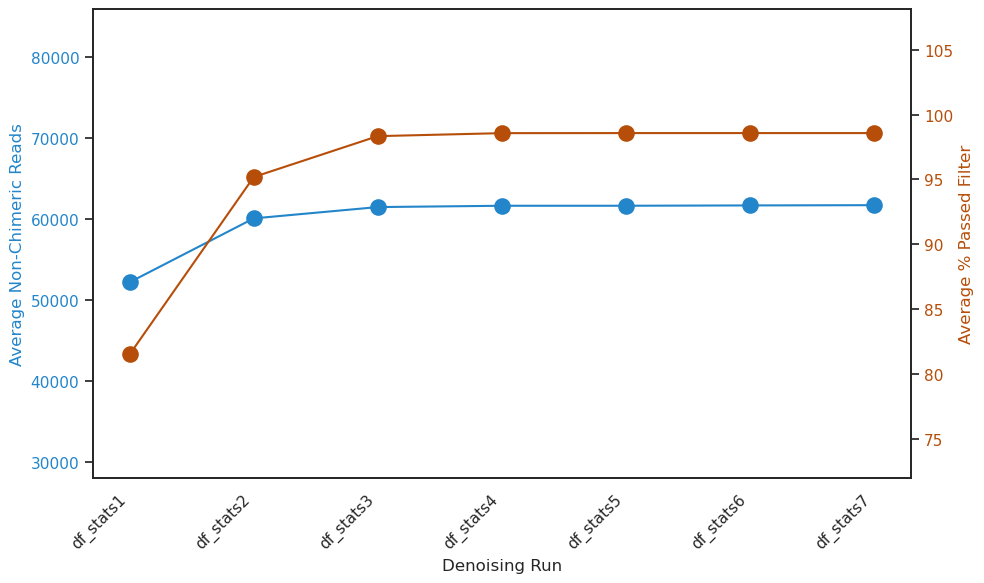

In [52]:
dfs = [df_stats1, df_stats2, df_stats3, df_stats4, df_stats5, df_stats6, df_stats7]

groups = ["df_stats1", "df_stats2", "df_stats3", "df_stats4", "df_stats5", "df_stats6", "df_stats7"]

# Mittelwerte links (non-chimeric)
mean_non_chimeric = [
    df_stats1["non-chimeric"].mean(),
    df_stats2["non-chimeric"].mean(),
    df_stats3["non-chimeric"].mean(),
    df_stats4["non-chimeric"].mean(),
    df_stats5["non-chimeric"].mean(),
    df_stats6["non-chimeric"].mean(),
    df_stats7["non-chimeric"].mean()
]

# Mittelwerte rechts (percentage of input passed filter)
mean_passed_filter = [
    df_stats1["percentage of input passed filter"].mean(),
    df_stats2["percentage of input passed filter"].mean(),
    df_stats3["percentage of input passed filter"].mean(),
    df_stats4["percentage of input passed filter"].mean(),
    df_stats5["percentage of input passed filter"].mean(),
    df_stats6["percentage of input passed filter"].mean(),
    df_stats7["percentage of input passed filter"].mean()
]


mean_nc = [df["non-chimeric"].mean() for df in dfs]
std_nc = [df["non-chimeric"].std() for df in dfs]

mean_pf = [df["percentage of input passed filter"].mean() for df in dfs]
std_pf = [df["percentage of input passed filter"].std() for df in dfs]


sns.set(rc={'figure.figsize': (10, 6)}, style='white')
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(groups, mean_non_chimeric, marker='o', color='#2385ca')
ax1.scatter(groups, mean_non_chimeric, color='#2385ca', s=120)
ax1.set_xlabel("Denoising Run")
ax1.set_ylabel("Average Non-Chimeric Reads", color='#2385ca')
ax1.tick_params(axis='y', labelcolor='#2385ca')

ax1.set_ylim(min(mean_nc) - max(std_nc)*1.2, max(mean_nc) + max(std_nc)*1.2)

plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(groups, mean_passed_filter, marker='o', color='#b64e0a')
ax2.scatter(groups, mean_passed_filter, color='#b64e0a', s=120)
ax2.set_ylabel("Average % Passed Filter", color='#b64e0a')
ax2.tick_params(axis='y', labelcolor='#b64e0a')

ax2.set_ylim(min(mean_pf) - max(std_pf)*1.2, max(mean_pf) + max(std_pf)*1.2)

plt.tight_layout()
plt.show()

## 03.02 Denoising our demultiplexed sequences using DADA2

Based on the obtained results from the denoising benchmarking, we opted for the values of 4 for max-ee and for min-fold-parent-over-abundance. Additionally, we decided not to truncate our sequences given that sequencing quality remaind high for the full length.

In [53]:
! qiime dada2 denoise-single \
   --i-demultiplexed-seqs $data_dir/02/fungut_forward_reads_trimmed.qza \
   --p-trim-left 0 \
   --p-trunc-len 0 \
   --p-min-fold-parent-over-abundance 4 \
   --p-max-ee 4 \
    --o-representative-sequences $data_dir/03/denoising_4/dada2_rep_seqs_4.qza \
    --o-table $data_dir/03/denoising_4/dada2_table_4.qza \
    --o-denoising-stats $data_dir/03/denoising_4/dada2_stats_4.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: data/03/denoising_4/dada2_table_4.qza
Saved FeatureData[Sequence] to: data/03/denoising_4/dada2_rep_seqs_4.qza
Saved SampleData[DADA2Stats] to: data/03/denoising_4/dada2_stats_4.qza


Perfect, the resulting feature table and the representative sequences will be the basis of all downstream processing.

# 04 Taxonomy 🍄‍🟫 

Great! Now that we have a finalised metadata file (for the time being...) and a denoised feature table, the last thing we need to make all the cool analyses later on is the taxonomic classification of our samples.

To classify our samples, we used a pretrained classifier (UNITE v10.0 2024-02-19 by colinbrislawn, dynmaic classifcation, all eukaryotes, including global and 97% singletons) and ran the script below on Euler to recieve a taxonomic classifiaction of our samples. In this notebook, we will first import the output file of the Euler-job and then we will first have a general look at our classification.

In [ ]:
"""

Below is the script we ran on euler to get our taxonomic classification:

#!/bin/bash
#SBATCH --job-name=taxonomy_job
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem-per-cpu=128G
#SBATCH --time=24:00:00
#SBATCH --output=taxonomy_output_%j.txt
#SBATCH --mail-type=END

module load stack/2024-06 gcc/12.2.0 python/3.10

source ~/miniconda3/etc/profile.d/conda.sh
conda activate qiime2-amplicon-2025.7


qiime feature-classifier classify-sklearn \
  --i-classifier unite_ver10_dynamic_s_all_19.02.2025-Q2-2024.10.qza \
  --i-reads rep_seqs_trimmed.qza \
  --p-reads-per-batch 1000 \
  --p-n-jobs 0 \
  --o-classification taxjobeuler.qza
"""

In [54]:
!wget "https://polybox.ethz.ch/index.php/s/ybCKaH8Poyz372C/download" -O $data_dir/04/taxjob_euler.qza

--2025-12-18 23:50:00--  https://polybox.ethz.ch/index.php/s/ybCKaH8Poyz372C/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128973 (126K) [application/octet-stream]
Saving to: ‘data/04/taxjob_euler.qza’

data/04/taxjob_eule 100%[===================>] 125.95K  --.-KB/s    in 0.002s  

2025-12-18 23:50:00 (80.4 MB/s) - ‘data/04/taxjob_euler.qza’ saved [128973/128973]



## 04.01 Taxonomy overview 

To have a first look at our taxonomic classification, we create the metadata table and the taxa barplots.

In [55]:
! qiime metadata tabulate \
    --m-input-file $data_dir/04/taxjob_euler.qza \
    --o-visualization $data_dir/04/taxonomy_overview.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/04/taxonomy_overview.qzv


In [56]:
Visualization.load(f"{data_dir}/04/taxonomy_overview.qzv")

<visualization: Visualization uuid: f862b9fb-f90a-4ee0-89c1-6f4db02b786a>

In [57]:
! qiime taxa barplot \
    --i-table $data_dir/03/denoising_4/dada2_table_4.qza \
    --i-taxonomy $data_dir/04/taxjob_euler.qza \
    --m-metadata-file $data_dir/metadata_ed.tsv \
    --o-visualization $data_dir/04/taxa_bar_plots_overview.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/04/taxa_bar_plots_overview.qzv


In [58]:
Visualization.load(f"{data_dir}/04/taxa_bar_plots_overview.qzv")

<visualization: Visualization uuid: cc0a3de3-9a5d-4471-867a-ce92fa2bdebc>

## 04.02 Filtering our data to exclude any non-fungal features

Looking at the taxonomic classification barplots, we see some non-fungal features and some samples with a high degree (>80%) of unclassifiable sequences. Let's have a look at some of these sequences using our metadata table and BLASTing the sequences. Here is an overview of randomly picked features:

| sample ID | BLAST | Reason for filtering |
|-------|-------|-------|
| fed424ac80555019c8816c6efb6f2004   | Fungal endophyte isolate   |  No precise classification   |
| 1ada978c8f3ff08af2668393869257ac    | Rhodotorula mucilaginosa  | Mostly from environmental sources | 
| 201dcc24ff7662a5eb05f31a0d0ca6c0    | no BLAST result found   |      |
| 270002b21dcf309398fe1f945dc902e0    | uncultured fugus   |      |
| 27e5e1e9ffac83de20b1ed2784cecee4    | Rhodotorula mucilaginosa   | Mostly from environmental sources |
| 288c841878718e65bd3f27b674c5b16a    | Mucor racemosus   | Mostly from environmental sources  |
| 31bd8178bf3013d48c62813a535b9e09 | Torulaspora delbrueckii |  Mostly from environmental sources |
| 3e2d3eecabe4355bd15aeab85aebaa83 | Rhodotorula mucilaginosa |  Mostly from environmental sources |
| 478e194c1ec118f79940439cc0c7fd36 | Cladosporium allicinum | plant leaves |
| 4af6fc99c1acf99c1b82d1db3a538c9e | Uncultured fungus | |
| 54e88722f1d30a88eaaf19efc686d249 | Uncultured basidiomycete |  |
| 58de98eb759b336275f22b9a976e97e1 | Rhodotorula mucilaginosa | Mostly from environmental sources |
| 5ad3902302653fe8bb0b938de1d18f68 | Uncultured fungus clone |  |
| 68da1589cb5aa90483bf9ddded795ff5 | Uncultured fungus clone |  |
| 73c2e92790e785ec39b58026ed4010ef | Candida glabrata |k__Fungi;p__Ascomycota;sp__Saccharomycotina;c__Saccharomycetes;o__Saccharomycetales;f__Saccharomycetaceae;g__Candida;s__glabrata
  |
| 818fb915612b44bbbd91b854c738a057 | Fungal endophyte | in plants |
| 97d39fb074a634f6e55e91dd89e69c89 | Blastocystis | parasit |
| a0dc22f3ab283a0afd30e730590fb85c | Uncultured fungus |  |
| a2805006a5012b036fa721982c1324fb | Rhizopus oryzae strain |Mostly from environmental sources|
| afbfe0c693e41ecdd14938a045832793 | Rhodotorula mucilaginosa |Mostly from environmental sources  |
| b2cf5a969f4c7a2f29d49b4216a39244 | Kluyveromyces marxianus | Mostly from environmental sources |
| beb8f130fd78d92d09b9aa1e37fec750 | Escherichia coli | Bacteria |
| c6a89f484b775e3a8a0842ec9d7568e1 | Uncultured fungus |  |
| c84004c0020de7d6ff5bde95677e8688 | Uncultured fungus |  |
| c9da8911059b1b0a4a2980d229a06a69 | Candida albicans  | k__Fungi;p__Ascomycota;sp__Saccharomycotina;c__Saccharomycetes;o__Saccharomycetales;f__Debaryomycetaceae;g__Candida;s__albicans
 |
| d8c7c2823a15d6d0e95a8003cf1cc15b | Rhodotorula mucilaginosa |Mostly from environmental sources  |
| d94d771c3041404138de7df8e52c6cd1 | Aethes rutilana genome assembly | Metazoa |
| ddf643cb96fee9d6ecd44d938b35bd61 | Uncultured fungus  |  |
| eff5b3a232c5c37acde9e8fc390d2c12 | no BLAST result found|  |
| fa340e00a973844b027665f54f7f6fb0 | Rhodotorula mucilaginosa  | Mostly from environmental sources |


As we can see from our randomly sampled unclassified features, almost all of the features stem from environmental sources or are from unclultured fungi. The features belonging to environmental samples and those belonging to plants and parasites are most likely contaminations that could distort downstream analyses. For this reason we decided to filter out any non-fungal features and only keep features that have have been classified to the level of class. We do this by using the qiime taxa filter-table/seqs commands:

In [59]:
! qiime taxa filter-table \
    --i-table $data_dir/03/denoising_4/dada2_table_4.qza \
    --i-taxonomy $data_dir/04/taxjob_euler.qza \
    --p-exclude Protista,Eukaryota_kgd_Incertae_sedis,Ichthyosporia,Metazoa,Viridiplantae \
    --p-include p__ \
    --o-filtered-table $data_dir/04/dada2_table_filtered.qza

! qiime taxa filter-seqs \
    --i-sequences $data_dir/03/denoising_4/dada2_rep_seqs_4.qza \
    --i-taxonomy $data_dir/04/taxjob_euler.qza \
    --p-exclude Protista,Eukaryota_kgd_Incertae_sedis,Ichthyosporia,Metazoa,Viridiplantae \
    --p-include p__ \
    --o-filtered-sequences $data_dir/04/dada2_rep_seqs_filtered.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: data/04/dada2_table_filtered.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Sequence] to: data/04/dada2_rep_seqs_filtered.qza


In [60]:
! qiime feature-table summarize \
    --i-table $data_dir/04/dada2_table_filtered.qza \
    --m-sample-metadata-file $data_dir/metadata_ed.tsv \
    --o-visualization $data_dir/03/denoising_4/dada2_table_4.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/03/denoising_4/dada2_table_4.qzv


## 04.03 Removing samples high in unclassifiable sequences and high in non-fungi

In our taxonomy barplots, we also saw some samples that are very high (>80%) in unclassified sequences or non-fungal sequences. As they are made up to a large degree of either contaminants or unclassifiable fungi, we want to filter these out to make sure they don't impact our downstream processing. To filter those out, we adjust our metadata and remove the IDs of the unwanted sequences. Then, we create a new feature table summary to see how many samples we lose in the process of filtering.

In [61]:
metadata_ed = pd.read_csv(f"{data_dir}/metadata_ed.tsv", sep="\t")

In [62]:
rem = ["ERR5327575", "ERR5327509", "ERR5327351", "ERR5327544", "ERR5327300", "ERR5327338", "ERR5327529", "ERR5327533", "ERR5327364", "ERR5327535"]

In [63]:
metadata_ed_rem = metadata_ed[~metadata_ed["ID"].isin(rem)]

In [64]:
metadata_ed_rem.to_csv(f"{data_dir}/metadata_ed_rem.tsv", sep="\t", index=False)

In [65]:
!qiime feature-table filter-samples \
    --i-table $data_dir/04/dada2_table_filtered.qza \
    --m-metadata-file $data_dir/metadata_ed_rem.tsv \
    --o-filtered-table $data_dir/04/dada2_table_filtered_samples_removed.qza 

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: data/04/dada2_table_filtered_samples_removed.qza


In [66]:
! qiime feature-table summarize \
  --i-table $data_dir/04/dada2_table_filtered_samples_removed.qza \
  --o-visualization $data_dir/04/dada2_table_metadata.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/04/dada2_table_metadata.qzv


In [67]:
Visualization.load(f"{data_dir}/04/dada2_table_metadata.qzv")

<visualization: Visualization uuid: cbff9972-a194-4f7d-8433-6a154d625e80>

## 04.04 Taxonomy after filtering

In the feautre table summary from the last visualisation, we see that we have now have 140 samples, 10 less than what we started with. Cool, now let's see what has changed in the taxonomic classification after filtering out the unwanted sequences:

In [68]:
!qiime taxa barplot \
    --i-table $data_dir/04/dada2_table_filtered_samples_removed.qza \
    --i-taxonomy $data_dir/04/taxjob_euler.qza \
    --m-metadata-file $data_dir/metadata_ed_rem.tsv \
    --o-visualization $data_dir/04/taxa_barplots_filtered.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/04/taxa_barplots_filtered.qzv


In [69]:
Visualization.load(f"{data_dir}/04/taxa_barplots_filtered.qzv")

<visualization: Visualization uuid: 4943f429-51ae-4189-81af-b1518f31870f>

# 05 The path to an appropriate sequencing depth 📐

To ensure a fair comparison of our samples (or what the pros call "statistically correct"), we need to standerdize sample sizes by randomly selecting a certain number of sequences from each sample. This certain number is the sequencing depth (SD) and in the following steps, we will dtermine the SD based on the output of alpha rarefaction performed at different max depths.

## 05.01 Finding an appropriate sequencing depth

First we look at the output we get when we do alpha rarefaction at the previuosly determined maximal depth of 30'000 based on previous trials. In the visualisation, we see that both the shannon value plateaus very quickly (already at 1000 features for all metadata columns) and the observed features also pleateau early for most metadata columns. Comparing with how many samples we loose (we don't loose any until around 20'000), we decided on a sequencing depth of around 20'000 as all curves have plateaued and we have not lost any samples yet.

In [70]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/04/dada2_table_filtered_samples_removed.qza \
    --p-max-depth 30000 \
    --m-metadata-file $data_dir/metadata_ed_rem.tsv \
    --o-visualization $data_dir/05/fungut_alpha_rarefaction_30000.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/05/fungut_alpha_rarefaction_30000.qzv


In [71]:
Visualization.load(f"{data_dir}/05/fungut_alpha_rarefaction_30000.qzv")

<visualization: Visualization uuid: 088e1246-0a35-4eb4-8096-89810f08f3ac>

To determine which seqencing depth we actually want to go for, we first look at how many samples we would lose for the three following sequencing depths (we did this by creating and summerzing new fature tables with varying --p-min-frequency):

    - 17'500: -> No sample lost
    - 20'000: -> 1 Sample lost
    - 22'500: -> 3 Samples lost
    
We decided to continue with a sequencing depth of 20'000.

## 05.02 Final check before Bootstrapping

As a quick check before bootstrapping and kmerizing our features, we perform alpha-rarefaction at a max depth of 23000 50 times to see if the randomness factor of alpha rarefaction might have lead to an unwanted bias. Luckily for us, we see no such effect in the output of this last check so we decided to continue with a SD of 20000. The code below is given as comments so that it does not delay the runtime, we just wanted to show what we did.

In [72]:
"""
!qiime diversity alpha-rarefaction \
  --i-table $data_dir/04/dada2_table_filtered.qza \
  --p-max-depth 23000 \
  --p-iterations 50 \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/05/alpha_rarefaction_sanitycheck.qzv
"""

'\n!qiime diversity alpha-rarefaction   --i-table $data_dir/04/dada2_table_filtered.qza   --p-max-depth 23000   --p-iterations 50   --m-metadata-file $data_dir/metadata_ed_rem.tsv   --o-visualization $data_dir/05/alpha_rarefaction_sanitycheck.qzv\n'

In [73]:
#Visualization.load(f"{data_dir}/05/alpha_rarefaction_sanitycheck.qzv")

# 06 Diversity analysis using bootstrapping 📊

Aaaalright, now that we have our sequencing depth, we can continue analyzing our data and perform diversity analysis. To do so, we investigate both alpha diversity (=within-sample diversity) and beta diversity (=between sample diversity). 

For the actual computation, we rely on k-mer–based diversity metrics. Recent puplications on ITS workflows show that k-mer methods outperform feature-table approaches by avoiding biases introduced during denoising and taxonomy assignment. In practice, this means we compute all diversity metrics directly from sequence-derived k-mers using qiime boots kmer-diversity. We perform this command at our previously selected sequencing depth and choose a kmer length of 16 after discussing the issue with our lovely TA. As we are running the bootstrapping at 1000 iterations, we must rely on the computational power of euler once again to run the job. Below, we will show the script we provided Euler and then we import the output directory using wget once more. 

## 06.01 Creating core metrics

### 06.01.01 Bootstrapping and kmerizing our ASVs on Euler 

In [74]:
# We ran the code below on euler to get our bootrstrapped diversity metrics.

"""

#!/bin/bash
#SBATCH --job-name=taxonomy_job
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem-per-cpu=128G
#SBATCH --time=24:00:00
#SBATCH --output=taxonomy_output_%j.txt
#SBATCH --mail-type=END


module load stack/2024-06 gcc/12.2.0 python/3.10

source ~/miniconda3/etc/profile.d/conda.sh
conda activate /cluster/scratch/lglauser/conda_envs/q2-boots-amplicon-2025.7
qiime dev refresh-cache

qiime boots kmer-diversity \
  --i-table /cluster/home/lglauser/boot/dada2_table_filtered_samples_removed.qza \
  --i-sequences /cluster/home/lglauser/boot/dada2_rep_seqs_filtered.qza \
  --m-metadata-file /cluster/home/lglauser/boot/metadata_ed_rem.tsv \
  --p-sampling-depth 20000 \
  --p-n 1000 \
  --p-replacement \
  --p-kmer-size 16 \
  --p-alpha-average-method median \
  --p-beta-average-method non-metric-median \
  --p-color-by "country_sample" \
  --output-dir /cluster/scratch/lglauser/boots_kmer_diversity_1000
  
"""

'\n\n#!/bin/bash\n#SBATCH --job-name=taxonomy_job\n#SBATCH --ntasks=1\n#SBATCH --cpus-per-task=1\n#SBATCH --mem-per-cpu=128G\n#SBATCH --time=24:00:00\n#SBATCH --output=taxonomy_output_%j.txt\n#SBATCH --mail-type=END\n\n\nmodule load stack/2024-06 gcc/12.2.0 python/3.10\n\nsource ~/miniconda3/etc/profile.d/conda.sh\nconda activate /cluster/scratch/lglauser/conda_envs/q2-boots-amplicon-2025.7\nqiime dev refresh-cache\n\nqiime boots kmer-diversity   --i-table /cluster/home/lglauser/boot/dada2_table_filtered_samples_removed.qza   --i-sequences /cluster/home/lglauser/boot/dada2_rep_seqs_filtered.qza   --m-metadata-file /cluster/home/lglauser/boot/metadata_ed_rem.tsv   --p-sampling-depth 20000   --p-n 1000   --p-replacement   --p-kmer-size 16   --p-alpha-average-method median   --p-beta-average-method non-metric-median   --p-color-by "country_sample"   --output-dir /cluster/scratch/lglauser/boots_kmer_diversity_1000\n  \n'

### 06.01.02 Importing our Euler results into the notebook

Now that we have run the job on euler, lets download the relevant outputs from the polybox as zip files and unzip them here to create our diversity analysis directory.

In [75]:
!wget "https://polybox.ethz.ch/index.php/s/dZCGqG66fdafKGB/download" -O $data_dir/06/boots-kmer-diversity/alpha_diversities.zip

--2025-12-18 23:57:57--  https://polybox.ethz.ch/index.php/s/dZCGqG66fdafKGB/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239231768 (228M) [application/zip]
Saving to: ‘data/06/boots-kmer-diversity/alpha_diversities.zip’

data/06/boots-kmer- 100%[===================>] 228.15M   221MB/s    in 1.0s    

2025-12-18 23:57:58 (221 MB/s) - ‘data/06/boots-kmer-diversity/alpha_diversities.zip’ saved [239231768/239231768]



In [76]:
! unzip $data_dir/06/boots-kmer-diversity/alpha_diversities.zip -d $data_dir/06/boots-kmer-diversity/

Archive:  data/06/boots-kmer-diversity/alpha_diversities.zip
   creating: data/06/boots-kmer-diversity/alpha_diversities/
 extracting: data/06/boots-kmer-diversity/alpha_diversities/observed_features.qza  
 extracting: data/06/boots-kmer-diversity/alpha_diversities/pielou_e.qza  
 extracting: data/06/boots-kmer-diversity/alpha_diversities/shannon.qza  


In [77]:
!wget "https://polybox.ethz.ch/index.php/s/Nppkb3p2GdgxjzN/download" -O $data_dir/06/boots-kmer-diversity/distance_matrices.zip

--2025-12-18 23:58:01--  https://polybox.ethz.ch/index.php/s/Nppkb3p2GdgxjzN/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159582191 (152M) [application/zip]
Saving to: ‘data/06/boots-kmer-diversity/distance_matrices.zip’

data/06/boots-kmer- 100%[===================>] 152.19M   168MB/s    in 0.9s    

2025-12-18 23:58:02 (168 MB/s) - ‘data/06/boots-kmer-diversity/distance_matrices.zip’ saved [159582191/159582191]



In [78]:
! unzip $data_dir/06/boots-kmer-diversity/distance_matrices.zip -d $data_dir/06/boots-kmer-diversity/

Archive:  data/06/boots-kmer-diversity/distance_matrices.zip
   creating: data/06/boots-kmer-diversity/distance_matrices/
 extracting: data/06/boots-kmer-diversity/distance_matrices/braycurtis.qza  
 extracting: data/06/boots-kmer-diversity/distance_matrices/jaccard.qza  


In [79]:
!wget "https://polybox.ethz.ch/index.php/s/arJ6ZLrxYYLJXwR/download" -O $data_dir/06/boots-kmer-diversity/pcoas.zip

--2025-12-18 23:58:04--  https://polybox.ethz.ch/index.php/s/arJ6ZLrxYYLJXwR/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159578691 (152M) [application/zip]
Saving to: ‘data/06/boots-kmer-diversity/pcoas.zip’

data/06/boots-kmer- 100%[===================>] 152.19M   195MB/s    in 0.8s    

2025-12-18 23:58:05 (195 MB/s) - ‘data/06/boots-kmer-diversity/pcoas.zip’ saved [159578691/159578691]



In [80]:
! unzip $data_dir/06/boots-kmer-diversity/pcoas.zip -d $data_dir/06/boots-kmer-diversity/

Archive:  data/06/boots-kmer-diversity/pcoas.zip
   creating: data/06/boots-kmer-diversity/pcoas/
 extracting: data/06/boots-kmer-diversity/pcoas/.order  
 extracting: data/06/boots-kmer-diversity/pcoas/braycurtis.qza  
 extracting: data/06/boots-kmer-diversity/pcoas/jaccard.qza  


## 06.02 Alpha diversity

### 06.02.01 Making and analyzing the plots

#### Categorical Variables

In [81]:
!qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/06/boots-kmer-diversity/alpha_diversities/shannon.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/06/alpha_diversity/alpha_shannon_group_significance.qzv

!qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/06/boots-kmer-diversity/alpha_diversities/observed_features.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/06/alpha_diversity/alpha_observed_features_group_significance.qzv

!qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/06/boots-kmer-diversity/alpha_diversities/pielou_e.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/06/alpha_diversity/alpha_pielou_e_group_significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/alpha_diversity/alpha_shannon_group_significance.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/alpha_diversity/alpha_observed_features_group_significance.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_reso

In [82]:
Visualization.load(f"{data_dir}/06/alpha_diversity/alpha_shannon_group_significance.qzv")

<visualization: Visualization uuid: 53d74b6a-5764-4206-a199-72bf7465f5ae>

In [83]:
Visualization.load(f"{data_dir}/06/alpha_diversity/alpha_observed_features_group_significance.qzv")

<visualization: Visualization uuid: 6c73d5f2-d18f-4b1d-bc8f-9e393436045c>

In [84]:
Visualization.load(f"{data_dir}/06/alpha_diversity/alpha_pielou_e_group_significance.qzv")

<visualization: Visualization uuid: f2257307-4511-4b4d-b67b-b645861c80ef>

#### Numeric Variables

In [85]:
!qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/06/boots-kmer-diversity/alpha_diversities/shannon.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/06/alpha_diversity/alpha_shannon_corrleation.qzv

!qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/06/boots-kmer-diversity/alpha_diversities/observed_features.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/06/alpha_diversity/alpha_observed_features_correlation.qzv

!qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/06/boots-kmer-diversity/alpha_diversities/pielou_e.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/06/alpha_diversity/alpha_pielou_e_correlation.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/alpha_diversity/alpha_shannon_corrleation.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/alpha_diversity/alpha_observed_features_correlation.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. Th

In [86]:
Visualization.load(f"{data_dir}/06/alpha_diversity/alpha_shannon_corrleation.qzv")

<visualization: Visualization uuid: 50cda57f-fecd-4d9e-8a85-f51cb81746b0>

In [87]:
Visualization.load(f"{data_dir}/06/alpha_diversity/alpha_observed_features_correlation.qzv")

<visualization: Visualization uuid: c273c8b7-2351-49b1-a0dc-fcc48cbb7963>

In [88]:
Visualization.load(f"{data_dir}/06/alpha_diversity/alpha_pielou_e_correlation.qzv")

<visualization: Visualization uuid: d2b5e45c-b08f-427e-b517-84aef24138b0>

### 06.02.2 Alpha diversity results

<div style="background-color: lightblue; padding: 20px;">
Analysing our alpha diversity plots for all three metrics of shannon, observed features and pielou we can conclude as follows:
</div>

## Results
**Diet type:**
- *Shannon:* The global tests shows significance with a p-value of p=0.03 (H=12.36). Pairwise testing revales multiple raw p-values below the significance thresshold of 0.05 with most of them involving the vegan group. Once adjusted for multiple comparisons, these p-values turn into q-values that no longer show significance with the q-value for the comparison between Omnivore vs. Vegans being slightly above the signifcance threshhold (q=0.07).
- *Observed features:* As for Shannon, the global test shows significance with a p-value of 0.0085 (H=15.49). Pairwise testing shows multiple pairings, again involving the vegan group, which remain significant even after correction for multiple testing (for example: Omnivore vs. Vegan q=0.023, Omnivore but no red meat vs. Vegan q=0.023, Vegan vs. Vegetarian q=0.023).
- *Pielou's evenness:* Unlike the other two metrics, global testing reveals an insignificant p-value of 0.355 (H=7.76). Pairwise testing also shows no significant pairings after correction.
- **Conclusion:** The results show that diet type primary affects the presence/absence and number of taxa, but not their relative evenness. In simple terms, we can conclude that diet seems to change which fungi are present, but nut how dominant the present fungi are.

**IBD Status:**
- *Shannon:* Global test shows no significance (p=0.07, H=7.07). Pairwise comparisons show significant raw p-value (p=0.012) for comparison between participants diagnosed with IBD and those which dont have the disease, but the corrected q=0.072 exceeds the significance threshhold. Thus we can see a weak suggestive difference in raw pairwise testing which are not robust once corrected. 
- *Observed features:* Global test shows no significance (p=0.15, H=5.34). As for shannon, pairwise comparisons show significant raw p-value (p=0.027) for comparison between participants diagnosed with IDB and those which dont have the disease, but the corrected q=0.16 exceeds the significance threshhold. 
- *Pielou's evenness:* Global test shows no significance (p=0.42, H=2.85). Subsequent pairwise testing shows no significance whatsoever. 
- **Conclusion:** Accross all three metrics, there is no statistical difference in alpha diversity based on IDB status after correcting for multiple testing. Raw p-values for pairings of Diagnosed vs. No-IBD show suggest potential association between IDB status and alpha diversity, additional testing with more targeted analysis would be required to confirm or refuse this association. 

**Celiac disease:**
- *Shannon:* Global testing shows no significance (p=0.094, H=7.94). Pairwise testing reveals a few significant raw p-values for the group of participants who don't eat gluten because it makes the feel bad but none survive correction for multiple comparisons.
- *Observed features:* No significance for the global (p=0.72, H=2.06) or any of the pairwise comparisons.
- *Pielou's evenness:* No significance for the global (p=0.31, H=2.4.82) or any of the pairwise comparisons.
- **Conclusion:** The results suggest no statistical difference in alpha diversity based on celiac diseas or gluten allergy status. 

**Age:** 
- *Shannon:* No significance. 
- *Observed features:* The results of spearman testing shows a modest, statistically significant (p=0.007, n=136) negative correlation (ρ =−0.23) between fungal richness and age. 
- *Pielou's evenness:* No significance.
- **Conclusion:** Age shows a small but significant negative association between fungal richness and age. Pielou and Shannon metrics show no significant association between fungal evenness and age.

**Other variables**
- No statistically relevant differences for the following variables:
    - Country
    - State
    - Sex
    - BMI
    - Rural/Urban/peri
    - All other numerical variables
    

## Conclusion
Accross all tested variables, diet type emerged as the factor with the highest association with alpha diversity in the FunGut cohort. Diet types were found to primarily affects fungal richness and to a lesser degree fungal diversity. These effects are largely driven by comparisons involving the vegan subgroup and were most robust for the richness-based metric of observed features, indicating differences in the number of detected taxa rather than their relative dominance. In contrast, no robust effects were found for IDB status and celiac disease after correction for multiple testing. This suggests that any potential associations found in raw p-values are weak and not detectable with the current sample size. Age showed a small but significant negative association between fungal richness and age but no effect on relative dominance of fungal taxa. Besides age, broad demographic or geographic factors were not found to drive significant differences in gut mycoviome alpha diversity within the FunGut cohort: no significant effect on alpha diversity was found for country of residence, urbanicity, sex, BMI, weight, height, latitude and longitude.  

Two major limitations call for caution when interpretating these results:
1. For the three health-rated metadata variables (Diet type, IDB status and celiac disease) there are vastly inhomogenious sample sizes (see metadata exploration in chapter 1.3), this limits statistical testing and may cause effects to be under- or overrepresentend. Further testing with larger sample sizes are required to better understand the effect these variables have on the alpha diversity in our samples.
2. The sequences found in stool samples compose of both microbial fungi and fungi present in ingested foodstuffs which pass the gut without colonisation before being excreted in the stool. All significant effects we osberve are therefore only directly associated with alpha diversity in stool sampels and do not directly translate to the diversity in fungal gut microbiome diversity.

## 06.03 Beta diversity

Next up, we will investigate between-sample diversity (=beta diversity) for which we take the beta diversity outputs from the q2 boots kmer diversity directory and convert them to emperor plots. In the plots we can then search for any clustering of our samples before assessing beta diversity in more detail by running PERMANOVA and ADONIS tests on metadata variables of interest.

### 06.03.01 Making the plots

In [89]:
# Bray–Curtis
!qiime emperor plot \
  --i-pcoa $data_dir/06/boots-kmer-diversity/pcoas/braycurtis.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/06/beta_diversity_plots/kmer_bray_emperor.qzv

# Jaccard
!qiime emperor plot \
  --i-pcoa $data_dir/06/boots-kmer-diversity/pcoas/jaccard.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/06/beta_diversity_plots/kmer_jaccard_emperor.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/beta_diversity_plots/kmer_bray_emperor.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/beta_diversity_plots/kmer_jaccard_emperor.qzv


In [90]:
Visualization.load(f"{data_dir}/06/beta_diversity_plots/kmer_bray_emperor.qzv")

<visualization: Visualization uuid: 3a4bc475-6762-4f2c-853c-01b1612be8cb>

In [91]:
Visualization.load(f"{data_dir}/06/beta_diversity_plots/kmer_jaccard_emperor.qzv")

<visualization: Visualization uuid: 941b72bc-8faf-4223-9fc7-f64b1b205b94>

### 06.03.02 PERMANOVA / ADONIS

Having observed no obvious clustering in our beta diversity plots, let us now check if we find statistically relevant differences between our samples using PERMANOVA. We will run permanova on both Bray-Curtis and Jaccard distance matrices.

In our metadata, we have information about the health of our participants, our main focus lies on the diet type, the diseases but also on the urbanicity of participants. Given that we have seen an effect of age on alpha diversity, we will also include beta diersity analysis for this numeric variable. The following variables will be investigated:
- Diet type
- IDB Status
- Celiac disease status
- Urbanicity
- Age

#### Diet type

In [92]:
# Pairwise Bray-Curtis
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/06/boots-kmer-diversity/distance_matrices/braycurtis.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column diet_type_sample \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/06/permanova/permanova_bray_diet_pairwise.qzv

# Pairwise Jaccard
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/06/boots-kmer-diversity/distance_matrices/jaccard.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column diet_type_sample \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/06/permanova/permanova_jaccard_diet_pairwise.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/permanova/permanova_bray_diet_pairwise.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/permanova/permanova_jaccard_diet_pairwise.qzv


In [93]:
Visualization.load(f"{data_dir}/06/permanova/permanova_bray_diet_pairwise.qzv")

<visualization: Visualization uuid: c49667d6-f781-455d-bc27-6c74624c8da5>

In [94]:
Visualization.load(f"{data_dir}/06/permanova/permanova_jaccard_diet_pairwise.qzv")

<visualization: Visualization uuid: bef03f84-7e11-432c-88cc-71531320f900>

#### IDB Status

In [95]:
# Pairwise Bray-Curtis
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/06/boots-kmer-diversity/distance_matrices/braycurtis.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column ibd_sample \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/06/permanova/permanova_bray_ibd_pairwise.qzv

# Pairwise Jaccard
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/06/boots-kmer-diversity/distance_matrices/jaccard.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column ibd_sample \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/06/permanova/permanova_jaccard_ibd_pairwise.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/permanova/permanova_bray_ibd_pairwise.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/permanova/permanova_jaccard_ibd_pairwise.qzv


In [96]:
Visualization.load(f"{data_dir}/06/permanova/permanova_bray_ibd_pairwise.qzv")

<visualization: Visualization uuid: a818f179-1aeb-42a0-b4c1-5688ec0a7709>

In [97]:
Visualization.load(f"{data_dir}/06/permanova/permanova_jaccard_ibd_pairwise.qzv")

<visualization: Visualization uuid: a2f66e56-3d29-4d49-a9ad-87531fc8cd3d>

#### Celiac disease

In [98]:
# Pairwise Bray-Curtis
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/06/boots-kmer-diversity/distance_matrices/braycurtis.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column gluten_sample \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/06/permanova/permanova_bray_gluten_pairwise.qzv

# Pairwise Jaccard
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/06/boots-kmer-diversity/distance_matrices/jaccard.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column gluten_sample \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/06/permanova/permanova_jaccard_gluten_pairwise.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/permanova/permanova_bray_gluten_pairwise.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/permanova/permanova_jaccard_gluten_pairwise.qzv


In [99]:
Visualization.load(f"{data_dir}/06/permanova/permanova_bray_gluten_pairwise.qzv")

<visualization: Visualization uuid: 0a24efd6-f641-4e55-8667-989dad5b7263>

In [100]:
Visualization.load(f"{data_dir}/06/permanova/permanova_jaccard_gluten_pairwise.qzv")

<visualization: Visualization uuid: a3826011-833d-4f40-966f-ccc1f4189a3c>

#### Urban / Rural score

In [103]:
# Pairwise Bray-Curtis
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/06/boots-kmer-diversity/distance_matrices/braycurtis.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column urban_rural \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/06/permanova/permanova_bray_rural_pairwise.qzv

# Pairwise Jaccard
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/06/boots-kmer-diversity/distance_matrices/jaccard.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column urban_rural \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/06/permanova/permanova_jaccard_rural_pairwise.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/permanova/permanova_bray_rural_pairwise.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/permanova/permanova_jaccard_rural_pairwise.qzv


In [104]:
Visualization.load(f"{data_dir}/06/permanova/permanova_bray_rural_pairwise.qzv")

<visualization: Visualization uuid: 1238a3f2-91fd-45bf-831a-afee8e011190>

In [105]:
Visualization.load(f"{data_dir}/06/permanova/permanova_jaccard_rural_pairwise.qzv")

<visualization: Visualization uuid: a98408e5-0ac6-4364-a002-ad6030292d84>

#### Age

As age is a numeric variable, we will be using ADONIS istead of PERMANOVA. Given that our metadata file contains some NaNs for the column "age_years_sample" we will eleiminate these samples before performing the ADONIS test for both Bray-Curtis and Jaccard distance matrices.

In [106]:
md_age = pd.read_csv(f"{data_dir}/metadata_ed_rem.tsv", sep="\t")
md_age = md_age.dropna(subset=["age_years_sample"])
md_age.to_csv("data/06/metadata_age.tsv", sep="\t", index=False)

In [107]:
!qiime diversity filter-distance-matrix \
  --i-distance-matrix $data_dir/06/boots-kmer-diversity/distance_matrices/braycurtis.qza \
  --m-metadata-file $data_dir/06/metadata_age.tsv \
  --o-filtered-distance-matrix $data_dir/06/permanova/braycurtis_age_filtered.qza

!qiime diversity filter-distance-matrix \
  --i-distance-matrix $data_dir/06/boots-kmer-diversity/distance_matrices/jaccard.qza \
  --m-metadata-file $data_dir/06/metadata_age.tsv \
  --o-filtered-distance-matrix $data_dir/06/permanova/jaccard_age_filtered.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: data/06/permanova/braycurtis_age_filtered.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: data/06/permanova/jaccard_age_filtered.qza


In [108]:
# Bray-Curtis
!qiime diversity adonis \
  --i-distance-matrix $data_dir/06/permanova/braycurtis_age_filtered.qza \
  --m-metadata-file $data_dir/06/metadata_age.tsv \
  --p-formula age_years_sample \
  --p-permutations 999 \
  --o-visualization $data_dir/06/permanova/adonis_bray_age.qzv


# Jaccard
!qiime diversity adonis \
  --i-distance-matrix $data_dir/06/permanova/jaccard_age_filtered.qza \
  --m-metadata-file $data_dir/06/metadata_age.tsv \
  --p-formula age_years_sample \
  --p-permutations 999 \
  --o-visualization $data_dir/06/permanova/adonis_jaccard_age.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/permanova/adonis_bray_age.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/permanova/adonis_jaccard_age.qzv


In [109]:
Visualization.load(f"{data_dir}/06/permanova/adonis_bray_age.qzv")

<visualization: Visualization uuid: c2954df8-d932-47f2-81ee-e24a48d6a4c2>

In [110]:
Visualization.load(f"{data_dir}/06/permanova/adonis_jaccard_age.qzv")

<visualization: Visualization uuid: 06af40aa-6869-493f-a80e-ad081d446c55>

### 06.03.03 Beta Diversity Results

<div style="background-color: lightblue; padding: 20px;">
Beta diversity analysis using PERMANOVA and ADONIS revealed the following key findings:
</div>

## Results

**Diet type:**
- *Bray-Curtis:* No global significance (p=0.987) and no significant p or q values in pairwise testing.
- *Jaccard:* No global significance (p=0.33) and some significant raw p-values only for pairwise comparisons including the vegan group. Correction for multiple comparisons shows significant q-values for Omnivore vs. Vegan (q=0.0375), Omnivore but no read meat vs. Vegan (q=0.0375) and Vegan vs Vegetarian (q=0.04). 
- **Conclusion:** PERMANOVA revealed no overall effect of diet type on beta diversity for both Bray-Curtis and Jaccard. However, Jaccard pairwise tests indicate that samples from vegan participants differ from omnivorous and vegetarian participants, sugesting differences in taxon presence/absence based on diet.

**IDB status:**
- *Bray-Curtis:* No global significance (p=0.71) and no significant p or q values in pairwise testing.
- *Jaccard:* No global significance (p=0.66) and no significant p or q values in pairwise testing.
- **Conclusion:** No effect of IDB status on beta diversity within our cohort.

**Celiac disease:**
- *Bray-Curtis:* No global significance (p=0.29) and no significant p or q values in pairwise testing.
- *Jaccard:* No global significance (p=0.88 ) and no significant p or q values in pairwise testing.
- **Conclusion:** No effect of celiac disease on beta diversity within our cohort.

**Urbanicity:**
- *Bray-Curtis:* No global significance (p=0.41) and no significant p or q values in pairwise testing.
- *Jaccard:* No global significance (p=0.85 ) and no significant p or q values in pairwise testing.
- **Conclusion:** No effect of urbanicity on beta diversity within our cohort.

**Age (Adonis testing with removed samples):**
- *Bray-Curtis:* No significance (p=0.08)
- *Jaccard:* Significanct association of age with community membership (p=0.009).
- **Conclusion:** Given that significance is only found in jaccard, we find that age is related to presence/absence patterns in funal taxa rather than relative abundances.
    
## Conclusion

Of all the variables of interest that were tested using PERMANOVA and ADONIS, most showed no detectable association with beta diersity. Diet type and age showed limited effects only detected when using Jaccard distance matrices suggesting that these variables are weakly associated with fungal taxon presence/absence differences. No significance in Bray-Curtis distance matrices suggests no effect on taxon abundances in our cohort. 

Just as with our findings from Alpha diversty analyses, these results must be interpreted with healthy dose of caution given that our group sizes are very inhomogenious with Omnivores (n=120) being a much larger group compared to Vegans or Vegetarians (both n=5). As PERMANOVA is sensitive to such imbalances, the observed significant p-values may therefore also reflect effects of unequal group sizes and can not be used as firm evidence for between sample-differences.


# 07 Differential Abundance 🧮

## 07.01 Filtering our features

Before we start with the *actual" abundnace analysis, let's prepare for it by improving the resolution of the downstream analysis. We do so by first filtering our feature table to only keep features that appear at least 25 times and in at least 4 samples. Then, we will collapse our taxonomic classification at the species level (=7) so that we can later check and compare the differential abundance both at the ASV level and at the species level.

In [111]:
# FT before filtering
# Summarize feature table (check per-sample read depth, number of features, and overall counts)
! qiime feature-table summarize \
    --i-table $data_dir/04/dada2_table_filtered_samples_removed.qza \
    --m-sample-metadata-file $data_dir/metadata_ed_rem.tsv \
    --o-visualization $data_dir/07/test_table_abundance_before_filtering.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/07/test_table_abundance_before_filtering.qzv


In [112]:
Visualization.load(f"{data_dir}/07/test_table_abundance_before_filtering.qzv")

<visualization: Visualization uuid: 94ad48c6-ab58-4ef9-b718-9a32b552187d>

In [113]:
! qiime feature-table filter-features \
    --i-table $data_dir/04/dada2_table_filtered_samples_removed.qza \
    --p-min-frequency 20 \
    --p-min-samples 3 \
    --o-filtered-table $data_dir/07/table_abundance_20_3.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: data/07/table_abundance_20_3.qza


In [114]:
# Summarize feature table (check per-sample read depth, number of features, and overall counts)
! qiime feature-table summarize \
    --i-table $data_dir/07/table_abundance_20_3.qza \
    --m-sample-metadata-file $data_dir/metadata_ed_rem.tsv \
    --o-visualization $data_dir/07/table_abundance_20_3.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/07/table_abundance_20_3.qzv


In [115]:
Visualization.load(f"{data_dir}/07/table_abundance_20_3.qzv")

<visualization: Visualization uuid: 6d293f67-64c2-4ec7-95dc-0805dff725d4>

In [116]:
! qiime taxa collapse \
    --i-table $data_dir/07/table_abundance_20_3.qza \
    --i-taxonomy $data_dir/04/taxjob_euler.qza \
    --p-level 7 \
    --o-collapsed-table $data_dir/07/table_abundance_collapsed.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: data/07/table_abundance_collapsed.qza


In [117]:
# Summarize feature table (check per-sample read depth, number of features, and overall counts)
! qiime feature-table summarize \
    --i-table $data_dir/07/table_abundance_collapsed.qza \
    --m-sample-metadata-file $data_dir/metadata_ed_rem.tsv \
    --o-visualization $data_dir/07/table_abundance_collapsed.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/07/table_abundance_collapsed.qzv


In [118]:
Visualization.load(f"{data_dir}/07/table_abundance_collapsed.qzv")

<visualization: Visualization uuid: 8c8dc411-81d5-4096-871e-59d164c58f0c>

## 07.02 Ancom-BC

Great! Let's now run the actual differnetial analysis, we will run Aconm-BC on the metadata variable of interest on both the ASV level and the species level.

#### Diet type

First for ASV level then also on species level (level 7)

In [119]:
#ASV LEVEL:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/07/table_abundance_20_3.qza \
    --m-metadata-file $data_dir/metadata_ed_rem.tsv \
    --p-formula diet_type_sample \
    --o-differentials $data_dir/07/ancombc/ancombc_diet_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/07/ancombc/ancombc_diet_differentials.qza \
    --o-visualization $data_dir/07/ancombc/ancombc_diet_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/07/ancombc/ancombc_diet_differentials.qza \
    --o-visualization $data_dir/07/ancombc/ancombc_diet_results.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: data/07/ancombc/ancombc_diet_differentials.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/07/ancombc/ancombc_diet_da_barplot.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_

In [120]:
#Species LEVEL:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/07/table_abundance_collapsed.qza \
    --m-metadata-file $data_dir/metadata_ed_rem.tsv \
    --p-formula diet_type_sample \
    --o-differentials $data_dir/07/ancombc/ancombc_diet_differentials_species.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/07/ancombc/ancombc_diet_differentials_species.qza \
    --o-visualization $data_dir/07/ancombc/ancombc_diet_da_barplot_species.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/07/ancombc/ancombc_diet_differentials_species.qza \
    --o-visualization $data_dir/07/ancombc/ancombc_diet_results_species.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: data/07/ancombc/ancombc_diet_differentials_species.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/07/ancombc/ancombc_diet_da_barplot_species.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resource

##### ASV Level:

In [121]:
Visualization.load(f"{data_dir}/07/ancombc/ancombc_diet_da_barplot.qzv")

<visualization: Visualization uuid: 3ce4d2bb-09ee-4663-ba46-a81734193297>

In [122]:
Visualization.load(f"{data_dir}/07/ancombc/ancombc_diet_results.qzv")

<visualization: Visualization uuid: 6ae4fefb-0135-4532-87d4-c8b911fd5dcc>

##### Species Level:

In [123]:
Visualization.load(f"{data_dir}/07/ancombc/ancombc_diet_da_barplot_species.qzv")

<visualization: Visualization uuid: b613c7d7-f678-4dca-8bd4-2ecaa1fad15c>

In [124]:
Visualization.load(f"{data_dir}/07/ancombc/ancombc_diet_results_species.qzv")

<visualization: Visualization uuid: 52f35136-0b99-4c71-ba5f-a1dbf70df5ed>

#### IDB Status

First for ASV level then also on species level (level 7)

In [50]:
cat /tmp/qiime2-q2cli-err-c6_40eiy.log

/opt/conda/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  series[missing.index] = missing
/opt/conda/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  series[missing.index] = missing
/opt/conda/lib/python3.10/site-packages/qiime2/metadata/metadata.py:610: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  seri

In [44]:
metadata_ed_rem = pd.read_csv(f"{data_dir}/metadata_ed_rem.tsv", sep="\t")

In [45]:
metadata_ibd = metadata.dropna(subset=["ibd_sample"])

In [46]:
metadata_ibd.to_csv("data/07/metadata_ibd.tsv", sep="\t", index=False)

In [49]:
!qiime feature-table filter-samples \
  --i-table $data_dir/07/table_abundance_20_3.qza \
  --m-metadata-file $data_dir/07/metadata_ibd.tsv \
  --o-filtered-table $data_dir/07/table_abundance_20_3_ibd.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: data/07/table_abundance_20_3_ibd.qza


In [42]:
#ASV LEVEL:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/07/table_abundance_20_3_ibd.qza \
    --m-metadata-file $data_dir/07/metadata_ibd.tsv \
    --p-formula ibd_sample \
    --o-differentials $data_dir/07/ancombc/ancombc_ibd_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/07/ancombc/ancombc_ibd_differentials.qza \
    --o-visualization $data_dir/07/ancombc/ancombc_ibd_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/07/ancombc/ancombc_ibd_differentials.qza \
    --o-visualization $data_dir/07/ancombc/ancombc_ibd_results.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Plugin error from composition:

  An error was encountered while running ANCOM-BC in R (return code 1), please inspect stdout and stderr to learn more.

Debug info has been saved to /tmp/qiime2-q2cli-err-c6_40eiy.log
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Usage: qiime composition da-barplot [OPTIONS]

  Generate bar plot views of ANCOM-BC output. One plot will be present per
  col

In [126]:
#Species LEVEL:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/07/table_abundance_20_3_ibd.qza \
    --m-metadata-file $data_dir/07/metadata_ibd.tsv \
    --p-formula ibd_sample \
    --o-differentials $data_dir/07/ancombc/ancombc_ibd_differentials_species.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/07/ancombc/ancombc_ibd_differentials_species.qza \
    --o-visualization $data_dir/07/ancombc/ancombc_ibd_da_barplot_species.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/07/ancombc/ancombc_ibd_differentials_species.qza \
    --o-visualization $data_dir/07/ancombc/ancombc_ibd_results_species.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Plugin error from composition:

  An error was encountered while running ANCOM-BC in R (return code 1), please inspect stdout and stderr to learn more.

Debug info has been saved to /tmp/qiime2-q2cli-err-9b5xt85b.log
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Usage: qiime composition da-barplot [OPTIONS]

  Generate bar plot views of ANCOM-BC output. One plot will be present per
  col

##### ASV Level:

In [127]:
Visualization.load(f"{data_dir}/07/ancombc/ancombc_ibd_da_barplot.qzv")

ValueError: data/07/ancombc/ancombc_ibd_da_barplot.qzv does not exist.

In [ ]:
Visualization.load(f"{data_dir}/07/ancombc/ancombc_ibd_results.qzv")

##### Species Level:

In [ ]:
Visualization.load(f"{data_dir}/07/ancombc/ancombc_ibd_da_barplot_species.qzv")

In [ ]:
Visualization.load(f"{data_dir}/07/ancombc/ancombc_ibd_results_species.qzv")

#### Celiac disease

First for ASV level then also on species level (level 7)

In [128]:
#ASV LEVEL:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/07/table_abundance_20_3.qza \
    --m-metadata-file $data_dir/metadata_ed_rem.tsv \
    --p-formula gluten_sample \
    --o-differentials $data_dir/07/ancombc/ancombc_gluten_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/07/ancombc/ancombc_gluten_differentials.qza \
    --o-visualization $data_dir/07/ancombc/ancombc_gluten_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/07/ancombc/ancombc_gluten_differentials.qza \
    --o-visualization $data_dir/07/ancombc/ancombc_gluten_results.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: data/07/ancombc/ancombc_gluten_differentials.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/07/ancombc/ancombc_gluten_da_barplot.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The 

In [129]:
#Species LEVEL:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $data_dir/07/table_abundance_collapsed.qza \
    --m-metadata-file $data_dir/metadata_ed_rem.tsv \
    --p-formula gluten_sample \
    --o-differentials $data_dir/07/ancombc/ancombc_gluten_differentials_species.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $data_dir/07/ancombc/ancombc_gluten_differentials_species.qza \
    --o-visualization $data_dir/07/ancombc/ancombc_gluten_da_barplot_species.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $data_dir/07/ancombc/ancombc_gluten_differentials_species.qza \
    --o-visualization $data_dir/07/ancombc/ancombc_gluten_results_species.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: data/07/ancombc/ancombc_gluten_differentials_species.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/07/ancombc/ancombc_gluten_da_barplot_species.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_reso

##### ASV Level:

In [130]:
Visualization.load(f"{data_dir}/07/ancombc/ancombc_gluten_da_barplot.qzv")

<visualization: Visualization uuid: e6fb42c8-631c-47e0-b1e3-611cfa8fc0d3>

In [131]:
Visualization.load(f"{data_dir}/07/ancombc/ancombc_gluten_results.qzv")

<visualization: Visualization uuid: 4097207f-4cf5-4a89-b582-4ce8907c6618>

##### Species Level:

In [132]:
Visualization.load(f"{data_dir}/07/ancombc/ancombc_gluten_da_barplot_species.qzv")

<visualization: Visualization uuid: 33e1b135-cde7-487b-a15f-43abe48b5749>

In [133]:
Visualization.load(f"{data_dir}/07/ancombc/ancombc_gluten_results_species.qzv")

<visualization: Visualization uuid: 256ed68f-777e-48c8-b393-8cb4d90bf481>

## 07.03 Differential abundance results

<div style="background-color: lightblue; padding: 20px;">
Analysing our ANCOM-BC results for the tested variables, we found the following results:
</div>

## Results
**Diet type:**
- ASV level: No significant feature
- Species Level: One significant feature found: Pichia kudriavzevii was found to be significantly increased in the vegan subgroup (n=5) with a lfc of 3.6 (q=0.037).

**IBD Status:**
- ASV level: No significant feature
- Species Level: One significant feature found: Pichia kudriavzevii was found to be significantly increased in the vegan subgroup (n=5) with a lfc of 3.6 (q=0.037).

**Celiac disease:**

**Age:** 

**Sex:**

**BMI:**


## Conclusion


# 08 Diversity analysis WITHOUT bootstrapping 🥾🚫

Having performed diversity analysis on our bootstrapped and kmerized sequences, we now want to perform alpha and beta diversity analysis with core metrics obtained through the "regular" pipeline of creating core metrics without bootstrapping. To do so, core metrics were created using the kmerizer plugin from the fine people at the Bokulich lab.

In [149]:
!qiime kmerizer core-metrics \
    --i-table $data_dir/04/dada2_table_filtered_samples_removed.qza \
    --i-sequences $data_dir/04/dada2_rep_seqs_filtered.qza \
    --m-metadata-file $data_dir/metadata_ed_rem.tsv \
    --p-sampling-depth 20000 \
    --p-kmer-size 16 \
    --output-dir $data_dir/08/kmerizer-results

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: data/08/kmerizer-results/rarefied_table.qza
Saved FeatureTable[Frequency] to: data/08/kmerizer-results/kmer_table.qza
Saved SampleData[AlphaDiversity] to: data/08/kmerizer-results/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: data/08/kmerizer-results/shannon_vector.qza
Saved DistanceMatrix to: data/08/kmerizer-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: data/08/kmerizer-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: data/08/kmerizer-results/jaccard_pcoa_results.qza
Saved PCoAResults to: data/08/kmerizer-results/bray_curtis_pcoa_results.qza
Saved Visualization to: data/08/kmerizer

## 08.02 Alpha diversity (kmerizer)

#### Categorical Variables

In [150]:
!qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/08/kmerizer-results/shannon_vector.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/08/alpha_diversity/alpha_shannon_group_significance_.qzv

!qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/08/kmerizer-results/observed_features_vector.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/08/alpha_diversity/alpha_observed_features_group_significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/08/alpha_diversity/alpha_shannon_group_significance_.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/08/alpha_diversity/alpha_observed_features_group_significance.qzv


In [151]:
Visualization.load(f"{data_dir}/08/alpha_diversity/alpha_shannon_group_significance_.qzv")

<visualization: Visualization uuid: 9097649a-9b30-4167-af27-533c710f6df2>

In [152]:
Visualization.load(f"{data_dir}/08/alpha_diversity/alpha_observed_features_group_significance.qzv")

<visualization: Visualization uuid: 2fa76196-0c14-42e3-b357-b0a1ba8a5071>

#### Numeric Variables

In [153]:
!qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/08/kmerizer-results/shannon_vector.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/08/alpha_diversity/alpha_shannon_corrleation.qzv

!qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/08/kmerizer-results/observed_features_vector.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/08/alpha_diversity/alpha_observed_features_correlation.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/08/alpha_diversity/alpha_shannon_corrleation.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/08/alpha_diversity/alpha_observed_features_correlation.qzv


In [154]:
Visualization.load(f"{data_dir}/08/alpha_diversity/alpha_shannon_corrleation.qzv")

<visualization: Visualization uuid: 07d09292-798c-41bb-9617-9fe9b6562ee5>

In [155]:
Visualization.load(f"{data_dir}/08/alpha_diversity/alpha_observed_features_correlation.qzv")

<visualization: Visualization uuid: eba432ab-0c3d-41a5-9ff7-cdd0b46a1480>

### 08.02.1 Alpha diversity findings 

<div style="background-color: lightblue; padding: 20px;">
Analysing our alpha diversity plots for the two metrics of shannon and observed features, we can conclude as follows:
</div>

**Diet type:**  
- Diet is associated with alpha diversity overall, both global Kruskal-Wallis tests were significant (Shannon p=0.021, Observed features p=0.006. We can conclude that some diet groups differ from others on these metrics. Pairwise testing shows that differences in richness (observed features) are robust for multiple comparisons (e.g. Omnivore vs Vegan; q=0.023). However, shannon diversity metrics do not survive correction for multiple comparisons (the lowest q-values is 0.053 for all pairwise testings which include the vegan group).

- *These results suggest that diet is associated mostly with the presene/absence of fungal taxa rather than with the evenness of their abundances. HOWEVER (and this is a big however), we must keep in mind that the small sample size of the vegan cohort (n=5) is a serious limitation of our analysis and analysis with larger sample sizes are required to confirm the effects found in this analysis.*

**IBD status:** 
- Kruskal-Wallis test for both Shannon and observed features shows no significant association with alpha diversity of the gut mycobiome of participants. Both metrics show p-values slightly above the significance threshhold (Shannon p=0.08, Observed features p=0.09). Although pairwise testing shows significant p-values for some pairings, once these values are adjusted for multiple comparisons though, non of the q-values show significance.
- *These results suggest that IBD status does not show a significant association with alpha diversity in the gut mycobiome of our cohort. Again, due to small samples sizes further analysis are needed to confirm or deny these findings.*

**Celiac Disease:**
- Kruskal-Wallis test for both Shannon and observed features shows no significant association with alpha diversity of the gut mycobiome of participants. Both metrics show p-values above the significance threshhold (Shannon p=0.19, Observed features p=0.48).
- *These results suggest that celiac disease status does not show a significant association with alpha diversity in the gut mycobiome of our cohort. And once more, due to small samples sizes further analysis are needed to confirm or deny these findings.*

**Age:**
- Global testing for osberved features reveals a significant p-Value of 0.0062 while shannon shows no significance. Age is weakly but significantly negatively associated with mycobiome richness.

**Remaining Variables:**
- No statistically relevant differences for all of the remaining variables:
    - Country
    - State
    - Sex
    - Urbanicity
    - BMI
    - Height
    - Weight
    - Latitude
    - Longitude

## 08.03 Beta diversity (kmerizer)

To investigate between-sample diversity (=beta diversity) we take the beta diversity outputs from the kmerizer directory and convert them to emperor plots. In the plots we can then search for any clustering of our samples.

### 08.03.01 Making the plots

In [156]:
# Bray–Curtis
!qiime emperor plot \
  --i-pcoa $data_dir/08/kmerizer-results/bray_curtis_pcoa_results.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/08/beta_diversity_plots/kmer_bray_emperor.qzv

# Jaccard
!qiime emperor plot \
  --i-pcoa $data_dir/08/kmerizer-results/jaccard_pcoa_results.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --o-visualization $data_dir/08/beta_diversity_plots/kmer_jaccard_emperor.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/08/beta_diversity_plots/kmer_bray_emperor.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/08/beta_diversity_plots/kmer_jaccard_emperor.qzv


In [157]:
Visualization.load(f"{data_dir}/08/beta_diversity_plots/kmer_bray_emperor.qzv")

<visualization: Visualization uuid: a042e30b-2ee2-45b1-8aca-e1e8c5d76805>

In [158]:
Visualization.load(f"{data_dir}/08/beta_diversity_plots/kmer_jaccard_emperor.qzv")

<visualization: Visualization uuid: 5220ef3d-9ba4-4574-8940-0b1acaa9b8bd>

### 08.03.02 PERMANOVA (kmerizer)

Having found no clear clustering in our beta diversity plots, let us now check if we find statistically relevant differences between our samples using PERMANOVA. As we are mainly interested in the health-related variables and have so far found no results that would have pointed us towards additional variables, we will perform PERMANOVA on the three variables of interest listed below:

Variables of interest:
- Diet type
- IDB status
- Celiac disease
- Age

#### Diet type

In [159]:
# Pairwise Bray-Curtis
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/08/kmerizer-results/bray_curtis_distance_matrix.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column diet_type_sample \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/08/permanova/permanova_bray_diet_pairwise.qzv

# Pairwise Jaccard
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/08/kmerizer-results/jaccard_distance_matrix.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column diet_type_sample \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/08/permanova/permanova_jaccard_diet_pairwise.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/08/permanova/permanova_bray_diet_pairwise.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/08/permanova/permanova_jaccard_diet_pairwise.qzv


In [160]:
Visualization.load(f"{data_dir}/08/permanova/permanova_bray_diet_pairwise.qzv")

<visualization: Visualization uuid: 8db8cf4b-fb68-43ec-bd63-ebde08769560>

In [161]:
Visualization.load(f"{data_dir}/08/permanova/permanova_jaccard_diet_pairwise.qzv")

<visualization: Visualization uuid: 0a8e8425-d655-42c1-9234-c3fc16f9f898>

#### IDB Status

In [162]:
# Pairwise Bray-Curtis
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/08/kmerizer-results/bray_curtis_distance_matrix.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column ibd_sample \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/08/permanova/permanova_bray_ibd_pairwise.qzv

# Pairwise Jaccard
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/08/kmerizer-results/jaccard_distance_matrix.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column ibd_sample \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/08/permanova/permanova_jaccard_ibd_pairwise.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/08/permanova/permanova_bray_ibd_pairwise.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/08/permanova/permanova_jaccard_ibd_pairwise.qzv


In [163]:
Visualization.load(f"{data_dir}/08/permanova/permanova_bray_ibd_pairwise.qzv")

<visualization: Visualization uuid: 38dcb043-de5c-4449-babc-d4fd515471f1>

In [164]:
Visualization.load(f"{data_dir}/08/permanova/permanova_jaccard_ibd_pairwise.qzv")

<visualization: Visualization uuid: d92b6d4a-9e0c-4fb8-8d64-6796c72d214a>

#### Celiac disease

In [165]:
# Pairwise Bray-Curtis
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/08/kmerizer-results/bray_curtis_distance_matrix.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column gluten_sample \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/08/permanova/permanova_bray_celiac_pairwise.qzv

# Pairwise Jaccard
!qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/08/kmerizer-results/jaccard_distance_matrix.qza \
  --m-metadata-file $data_dir/metadata_ed_rem.tsv \
  --m-metadata-column gluten_sample \
  --p-method permanova \
  --p-permutations 999 \
  --p-pairwise \
  --o-visualization $data_dir/08/permanova/permanova_jaccard_celiac_pairwise.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/08/permanova/permanova_bray_celiac_pairwise.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/08/permanova/permanova_jaccard_celiac_pairwise.qzv


In [166]:
Visualization.load(f"{data_dir}/08/permanova/permanova_bray_celiac_pairwise.qzv")

<visualization: Visualization uuid: ff0f7011-98b9-4305-af6e-8eedbfa88c69>

In [167]:
Visualization.load(f"{data_dir}/08/permanova/permanova_jaccard_celiac_pairwise.qzv")

<visualization: Visualization uuid: d270daa7-ba9a-4f2d-8ca9-bf150ec667e0>

#### Age

As age is a numeric variable, we will be using ADONIS istead of PERMANOVA. Given that our metadata file contains some NaNs for the column "age_years_sample" we will eleiminate these samples before performing the ADONIS test for both Bray-Curtis and Jaccard distance matrices.

In [168]:
!qiime diversity filter-distance-matrix \
  --i-distance-matrix $data_dir/08/kmerizer-results/bray_curtis_distance_matrix.qza \
  --m-metadata-file $data_dir/06/metadata_age.tsv \
  --o-filtered-distance-matrix $data_dir/08/permanova/braycurtis_age_filtered_kmerizer.qza

!qiime diversity filter-distance-matrix \
  --i-distance-matrix $data_dir/08/kmerizer-results/jaccard_distance_matrix.qza \
  --m-metadata-file $data_dir/06/metadata_age.tsv \
  --o-filtered-distance-matrix $data_dir/08/permanova/jaccard_age_filtered_kmerizer.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: data/08/permanova/braycurtis_age_filtered_kmerizer.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: data/08/permanova/jaccard_age_filtered_kmerizer.qza


In [169]:
# Bray-Curtis
!qiime diversity adonis \
  --i-distance-matrix $data_dir/08/permanova/braycurtis_age_filtered_kmerizer.qza \
  --m-metadata-file $data_dir/06/metadata_age.tsv \
  --p-formula age_years_sample \
  --p-permutations 999 \
  --o-visualization $data_dir/06/permanova/adonis_bray_age_kmerizer.qzv


# Jaccard
!qiime diversity adonis \
  --i-distance-matrix $data_dir/08/permanova/jaccard_age_filtered_kmerizer.qza \
  --m-metadata-file $data_dir/06/metadata_age.tsv \
  --p-formula age_years_sample \
  --p-permutations 999 \
  --o-visualization $data_dir/08/permanova/adonis_jaccard_age_kmerizer.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/06/permanova/adonis_bray_age_kmerizer.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/08/permanova/adonis_jaccard_age_kmerizer.qzv


In [170]:
Visualization.load(f"{data_dir}/06/permanova/adonis_bray_age_kmerizer.qzv")

<visualization: Visualization uuid: 782daa9c-0933-47a5-9bf4-952ce9ce6777>

In [171]:
Visualization.load(f"{data_dir}/08/permanova/adonis_jaccard_age_kmerizer.qzv")

<visualization: Visualization uuid: 9a64bb06-8c4d-4cdf-a5a0-b09d0494a2da>

### 08.03.03 Beta diversity findings

<div style="background-color: lightblue; padding: 20px;">
Analysing PERMANOVA results based on both Bray-Curtis and Jaccard distance matrices, we can conclude as follows:
</div>

**Diet type:**  
- Diet is not associated with beta diversity when abundance information is considered: Bray-Curtis PERMANOVA testing results in a non-significant p-Value (p=0.959) which indicates no overall differences in fungal composition across diet groups when we weigh based on abundance.
- However, if we dont weight based on abundance and perform PERMANOVA based on Jaccard, we find diet-related differences for specific comparisons. Although, the global PERMANOVA test was not significant (p=0.357), certain comparisons involving the vegan group were significant even after correction for multiple comparisons (e.g. Omnivore vs. Vegan p=0.035). This suggests that diet type plays a role in which fungal taxa are present in our cohort but not in their relative abundances.
- *Conclusion: Our results confirm previous findings in Alpha-diversity testing: They show that diet is primarily associated with fungal taxon presence/absence in the gut mycobiomes of the FunGut cohort rather than with their abundances. But, and you may have seen this coming, the vast difference in group sizes drastically limit the power of these results.*

**IBD status:** 
- Bray-Curtis: Results suggest no significant association of IBD status and beta diversity, the global PERMANOVA test was non-significant (p=0.679) and neither were any of the pairwise comparisons.
- Jaccard: Just as for Bray-Curtis, our analysis show no significance whatsoever. The global p-value was 00543.
- *Conclusion: Our results show no statistically relevant difference in beta diversity between diagnosed IBD and other participants in our cohort.*


**Celiac Disease:**
- Bray-Curtis: Just as with IBD, both the global PERMANOVA (p=0.769) and all pairwise PERMANOVA tests are non-significant.
- Jaccard: Likewise, no evidence of differnces in presence/absence of fungal taxa based on celiac disease status was found. The global p-Value was 0.769 and no pairings showed significance.
- *Conclusion: Our results show no statistically relevant difference in beta diversity between diagnosed celiac disease and other participants in our cohort.* 

**Age (Adonis testing with removed samples):**
- *Bray-Curtis:* No significance (p=0.08)
- *Jaccard:* Significanct association of age with community membership (p=0.009).
- **Conclusion:** Given that significance is only found in jaccard, we find that age is related to presence/absence patterns in funal taxa rather than relative abundances.
    

**Conclusion:** 
- Of the three tested health-related variables, only the type of diet showed to be associated with presence/absence based beta diversity with the vegan diet showing significant differences in beta diversity when paired with any other group except for "Not provided". 
- Additionally, Age shows significance in beta duversity being related to richness rather than evenness.

## 08.04 Comparing bootstrapped results to non bootstrapped

<div style="background-color: lightblue; padding: 20px;">
The two pipelines of creating and analysing diversity metrics are compared in this section:
</div>

**Alpha diversity**

Both methods of creating alpha diversity metrics (bootstrapping and kmerizer) yield largly congruent alpha diversity results: Both analyses identify diet type and age as the only robust associations with alpha diversity and for both anaylses the observed effects are driven by richness rather than evenness. Additionally, both methods identify the vegan group as the driver of alpha diversity differences for the variable diet type. Neither method revealed a significant global effect of IBD status or celiac disease on alpha diversity.

**Beta diversity**

Simliarly, both workflows (boots and kmerizer) yield highly consistent results for beta diversity. Both methods show no associations with Bray-Curtis distances indicating no detectable on abundance-weighted community composition. Using Jaccard distances, both methods identify significant effects for both diet type and age. No significant associations are observed for IBD status and celiac disease in either workflow. 

**Conclusion**
Overall, the two methodologies yielded the same results with only minor deviations in p- and q values obtained. These slight differences are most likely due to statistical sensitivity.

# 09 Functional analysis

## What is FUNGuild

FUNGuild is an annotation tool that can predict and classify the ecological roles of the fungi based on their taxonomic assignment. The wanted parameter from this tool was "trophic mode". With the taxonomic assignment, FUNGuild can annotate a trophic mode which describes the ecological role of the fungi.
These roles are patotrophs, saprotroph and symbiotrophs. Pathotrophs gain nutrients by invasion of a host organisms, saprotrophs decomposes non-living organic material like plants and symbiotrophs form mutually beneficial relationships with a host.
An even more specific classifications is represented by the "guilds". As these guilds are too different from each other, they were not taken further into account, as a comparison between them would bee to broad.  

To run the comparison, FUNGuild requires a plain-text taxonomy table. Therefore the Qiime2 taxonomy artifact was first exported to a tsv file. This taxonomy file was then filtered to include only the features that were retained in the previously filtered feature table, to make sure that functional assignments were performed only for features present in the final dataset. The resulting filtered taxonomy table was then formatted according to FUNGuild’s input requirements and then compared with the FUNGuild tool.

Source:
FUNGuild: An open annotation tool for parsing fungal community datasets by ecological guild https://www.sciencedirect.com/science/article/pii/S1754504815000847?via%3Dihub

## FUNGuild annotation

In [12]:
# convert qza files to a format readable for FUNGuild
# Prepare paths
taxonomy_qza_path = f"{data_dir}/04/taxjob_euler.qza"
table_filtered_qza_path = f"{data_dir}/04/dada2_table_filtered_samples_removed.qza"

taxonomy_artifact = Artifact.load(taxonomy_qza_path)
taxonomy_artifact.export_data(f"{data_dir}/09")

table_filtered_artifact = Artifact.load(table_filtered_qza_path)
table_filtered_artifact.export_data(f"{data_dir}/09")

# convert from biom to tsv and create a file for the filtered ids, that the ids match for both documents
feature_table_biom_path = f"{data_dir}/09/feature-table.biom"
feature_table_tsv_path = f"{data_dir}/09/feature-table.tsv"
filtered_ids_path = f"{data_dir}/09/filtered_ids.txt"

biom_table = load_table(feature_table_biom_path)
with open(feature_table_tsv_path, "w") as f:
    f.write(biom_table.to_tsv())

with open(feature_table_tsv_path) as infile:
    with open(filtered_ids_path, "w") as outfile:
        for i, line in enumerate(infile):
            if i < 2:
                continue  
            asv_id = line.split("\t")[0]
            outfile.write(asv_id + "\n")

# Prepare taxonomy for FUNGuild
taxonomy_tsv_path = f"{data_dir}/09/taxonomy.tsv"
filtered_taxonomy_path = f"{data_dir}/09/taxonomy_filtered.tsv"

taxonomy_df = pd.read_csv(taxonomy_tsv_path, sep="\t")
with open(filtered_ids_path) as f:
    asv_ids = set(line.strip() for line in f)

filtered_taxonomy_df = taxonomy_df[taxonomy_df["Feature ID"].isin(asv_ids)]
filtered_taxonomy_df.to_csv(filtered_taxonomy_path, sep="\t", index=False)

funguild_input_path = f"{data_dir}/09/taxonomy_filtered_for_funguild.txt"
funguild_output_path = f"{data_dir}/09/taxonomy_filtered_for_funguild.guilds.tsv"

filtered_taxonomy_df = filtered_taxonomy_df.rename(columns={"Taxon": "taxonomy"})
filtered_taxonomy_df.to_csv(funguild_input_path, sep="\t", index=False)


In [13]:
# Run FUNGuild
os.system(f"git clone https://github.com/UMNFuN/FUNGuild {data_dir}/09/FUNGuild")
os.system(f"python {data_dir}/09/FUNGuild/Guilds_v1.1.py -otu {funguild_input_path} -db fungi")

# Rename the generated file
os.rename(f"{data_dir}/09/taxonomy_filtered_for_funguild.guilds.txt", funguild_output_path)

Cloning into 'data/09/FUNGuild'...


FunGuild v1.1 Beta
Connecting with FUNGuild database ...

Reading in the OTU table: 'data/09/taxonomy_filtered_for_funguild.txt'

Searching the FUNGuild database...
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%

Found 1154 matching taxonomy records in the database.
Dereplicating and sorting the result...
FunGuild tried to assign function to 907 OTUs in 'data/09/taxonomy_filtered_for_funguild.txt'.
FUNGuild made assignments on 709 OTUs.
Result saved to 'data/09/taxonomy_filtered_for_funguild.guilds.txt'

Total calculating time: 5.41 seconds.


In [14]:
funguild_df = pd.read_csv(f"{data_dir}/09/taxonomy_filtered_for_funguild.guilds.tsv", sep="\t")

In [15]:
funguild_df.head(2)

,Feature ID,taxonomy,Confidence,Taxon,Taxon Level,Trophic Mode,Guild,Growth Morphology,Trait,Confidence Ranking,Notes,Citation/Source
0,0048079d52e0b654423c0c89021b8a34,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...,0.873261,Pleurotus,13,Pathotroph-Saprotroph,Endophyte-Nematophagous-Plant Pathogen-|Wood S...,Agaricoid,White Rot,Probable,As white_rot (Põlme et al. 2020); As wood_path...,"James TY, et al. 2006. Nature 443:818-822 ((ht..."
1,004c991a685b11054001b8c7d0a68543,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.940547,Saccharomycetales,7,Saprotroph,Undefined Saprotroph,Yeast,NaN,Possible,NaN,"Sterkenburg E, et al. 2015. New Phytologist 20..."


## FUNGuild data analysis

In [16]:
# The unassigned samples are replaced with "unassigned"
# Trophic mode
funguild_df['Trophic Mode'] = funguild_df['Trophic Mode'].str.strip()

# match "Unassigned" 
funguild_df['Trophic Mode'] = funguild_df['Trophic Mode'].replace({'-': 'Unassigned', '': 'Unassigned'})

# count trophic mode
trophic_mode_counts = funguild_df['Trophic Mode'].value_counts()

print(trophic_mode_counts)


Trophic Mode
Saprotroph                           312
Pathotroph-Saprotroph                212
Unassigned                           198
Pathotroph-Saprotroph-Symbiotroph    157
Saprotroph-Symbiotroph                15
Pathotroph                             8
Pathotroph-Symbiotroph                 3
Pathotroph-Pathotroph-Saprotroph       1
Symbiotroph                            1
Name: count, dtype: int64


In [17]:
# Plots to compare the trophic modes
# First, some colomns have to be renamed
feature_table = pd.read_csv(f"{data_dir}/09/feature-table.tsv", sep='\t', skiprows=1)
feature_table = feature_table.rename(columns={'#OTU ID': 'FeatureID'})

funguild_df = funguild_df.rename(columns={'Feature ID':'FeatureID'})

# Then the feature table can be merged with the funguild table
merged_fg_ft = feature_table.merge(funguild_df, on='FeatureID', how='left')

exclude_cols = ['FeatureID','Guild','Trophic Mode','Confidence']
sample_cols = [c for c in merged_fg_ft.columns if c not in exclude_cols]

# And we create tsv files filtered by the trophic mode

trophic = merged_fg_ft.groupby('Trophic Mode')[sample_cols].sum()
trophic.to_csv(f"{data_dir}/09/trophic_by_sample.tsv", sep='\t')


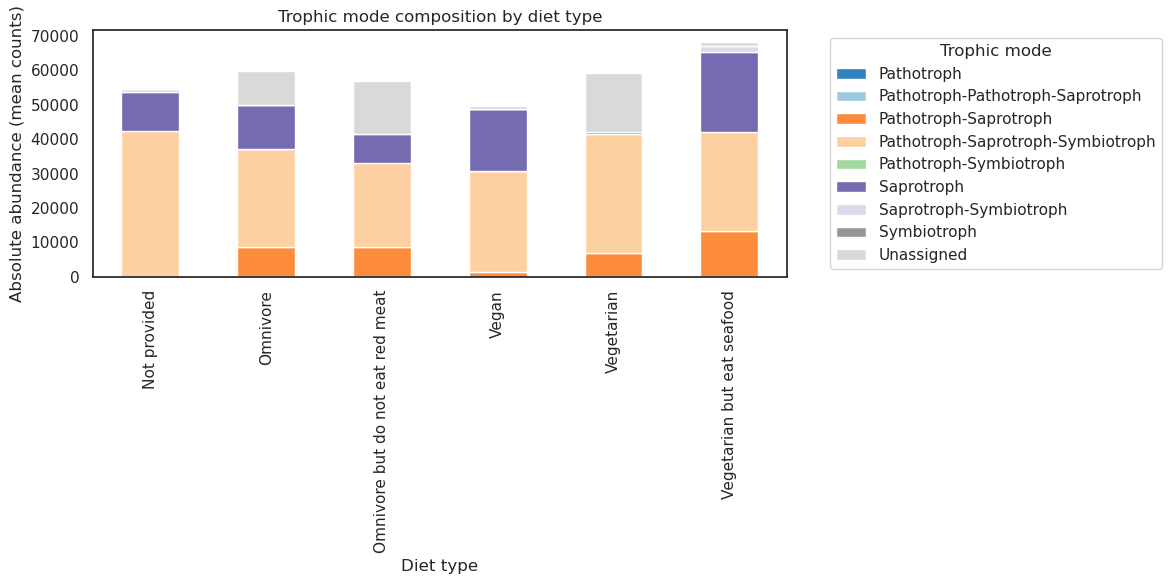

In [19]:
# Trophic mode by diet type

guild_abund = pd.read_csv(f"{data_dir}/09/trophic_by_sample.tsv", sep='\t', index_col=0)
guild_abund_T = guild_abund.T
guild_abund_T.index.name = 'ID'
guild_abund_T = guild_abund_T.reset_index()

metadata = pd.read_csv(f"{data_dir}/metadata_ed_rem.tsv", sep='\t')
merged = metadata.merge(guild_abund_T, on='ID')

# Guild-Spalten identifizieren
guild_cols = [c for c in merged.columns if c not in metadata.columns]

# Mittelwerte pro Diet Type berechnen (absolute Counts)
diet_means = merged.groupby('diet_type_sample')[guild_cols].mean()

# Plot: absolute Abundanzen
ax = diet_means.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20c")
plt.ylabel("Absolute abundance (mean counts)")
plt.xlabel("Diet type")
plt.title("Trophic mode composition by diet type")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Trophic mode")
plt.tight_layout()
plt.show()

/tmp/ipykernel_211/1095063980.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


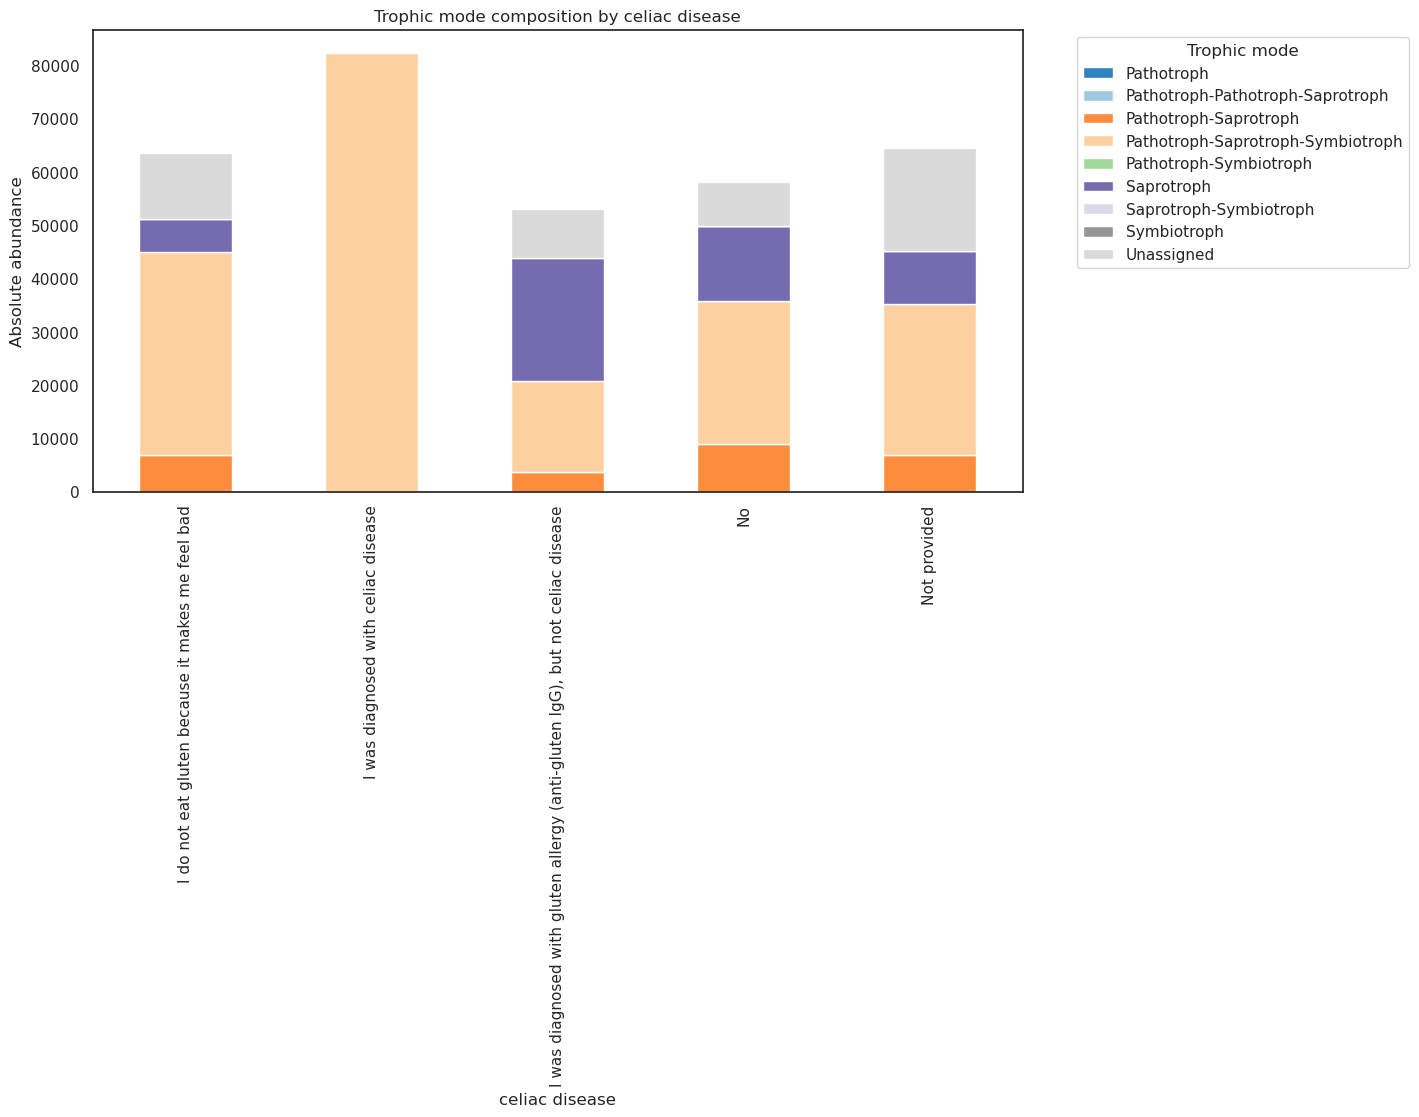

In [21]:
# Trophic mode by celiac disease

guild_abund = pd.read_csv(f"{data_dir}/09/trophic_by_sample.tsv", sep='\t', index_col=0)
guild_abund_T = guild_abund.T
guild_abund_T.index.name = 'ID'
guild_abund_T = guild_abund_T.reset_index()

metadata = pd.read_csv(f"{data_dir}/metadata_ed_rem.tsv", sep='\t')
merged = metadata.merge(guild_abund_T, on='ID')

# Guild-Spalten identifizieren
guild_cols = [c for c in merged.columns if c not in metadata.columns]

# Mittelwerte pro Diet Type berechnen (absolute Counts)
diet_means = merged.groupby('gluten_sample')[guild_cols].mean()

# Plot: absolute Abundanzen
ax = diet_means.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20c")
plt.ylabel("Absolute abundance")
plt.xlabel("celiac disease")
plt.title("Trophic mode composition by celiac disease")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Trophic mode")
plt.tight_layout()
plt.show()

/tmp/ipykernel_211/1623580389.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


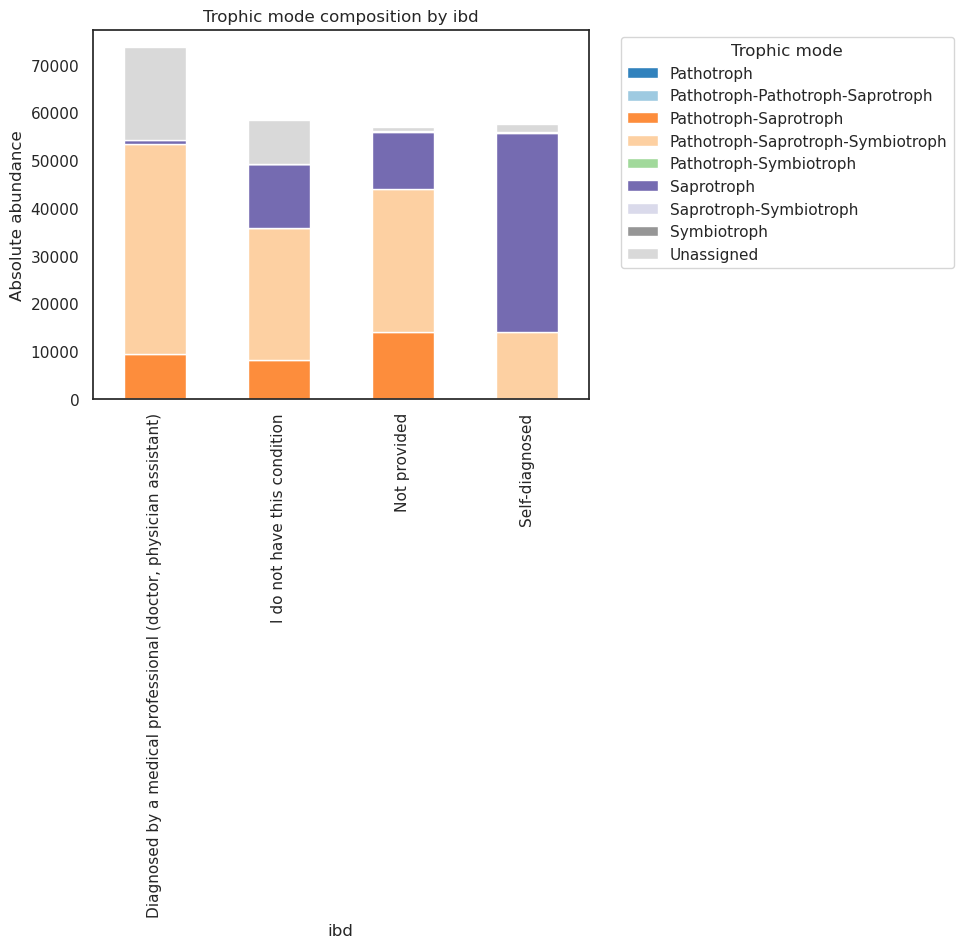

In [22]:
# Trophic mode by ibd

guild_abund = pd.read_csv(f"{data_dir}/09/trophic_by_sample.tsv", sep='\t', index_col=0)
guild_abund_T = guild_abund.T
guild_abund_T.index.name = 'ID'
guild_abund_T = guild_abund_T.reset_index()

metadata = pd.read_csv(f"{data_dir}/metadata_ed_rem.tsv", sep='\t')
merged = metadata.merge(guild_abund_T, on='ID')

# Guild-Spalten identifizieren
guild_cols = [c for c in merged.columns if c not in metadata.columns]

# Mittelwerte pro Diet Type berechnen (absolute Counts)
diet_means = merged.groupby('ibd_sample')[guild_cols].mean()

# Plot: absolute Abundanzen
ax = diet_means.plot(kind="bar", stacked=True, colormap="tab20c")
plt.ylabel("Absolute abundance")
plt.xlabel("ibd")
plt.title("Trophic mode composition by ibd")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Trophic mode")
plt.tight_layout()
plt.show()

<div style="background-color: lightblue; padding: 20px;">
To conclude the functional analysis, we searched for any visual correlations without performing statistical testings:
</div>

**Conclusion:** The quantity of saprotrophs compared to symbiotroph or pathotroph is higher among all results. Symbiotroph and pathotroph appear only together with saprotoph, they never appear on their own. This could be because diets rich in plant materials can enhance saprotrophic activity, as the fungal community is oriented towards the decompostion of this plant materials. 
For further analysis, statistcal test would have to been performed and a higher quantity of samples have to be obtained to get a meanigful analysis. 


